In [1]:
import sys

# sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("C:/Users/your-username/AppData/Local/Programs/Python/Python312/Lib/site-packages")
# sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt 
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files


In [3]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(glob("cali_files/bitonic_cali/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 269/269 [00:03<00:00, 82.33it/s] 
C:\Users\kelvi\anaconda3\Lib\site-packages\thicket\ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


In [ ]:
print(tk.tree(metric_column="Avg time/rank"))

View Calltree


Group Performance data by `matrix_size` in the Thicket metadata table.


In [ ]:
tk.metadata_column_to_perfdata("algorithm")
tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("input_type")
tk.metadata_column_to_perfdata("num_procs")

tk.dataframe = tk.dataframe.reset_index().set_index(["node", "algorithm", "input_size", "input_type", "num_procs"]).sort_index()

tk.dataframe.head()

In [ ]:
tk.dataframe

In [ ]:
tk.metadata

In [10]:
# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
input_types = ["sorted", "random", "reverse", "perturbed"]

In [13]:
def plot_pandas(df, title, xlabel, ylabel):
    plot = df.plot(kind="line", 
        marker='o', 
        title=title, 
        xlabel=xlabel,
        ylabel=ylabel, 
        figsize=(15,7),
        grid=True
    )
    return plot

In [15]:
# Change font size for all plots
plt.rcParams.update({"font.size": 20})

In [17]:
for node in tk.graph.traverse():
    if node.frame["name"] != 'main' and node.frame["name"] != 'comm' and node.frame["name"] != 'comp_large':
        continue
    print(node)

{'name': 'main', 'type': 'function'}
{'name': 'main', 'type': 'function'}
{'name': 'comm', 'type': 'function'}
{'name': 'comm', 'type': 'function'}
{'name': 'comp_large', 'type': 'function'}


C:\Users\kelvi\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


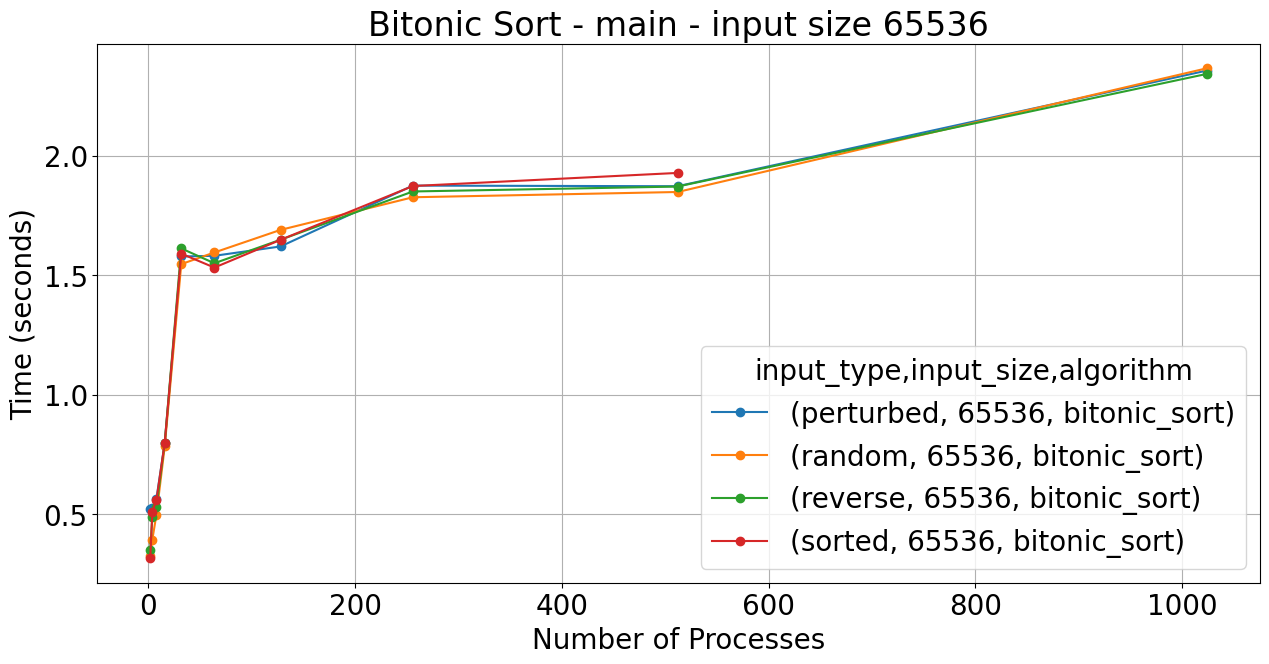

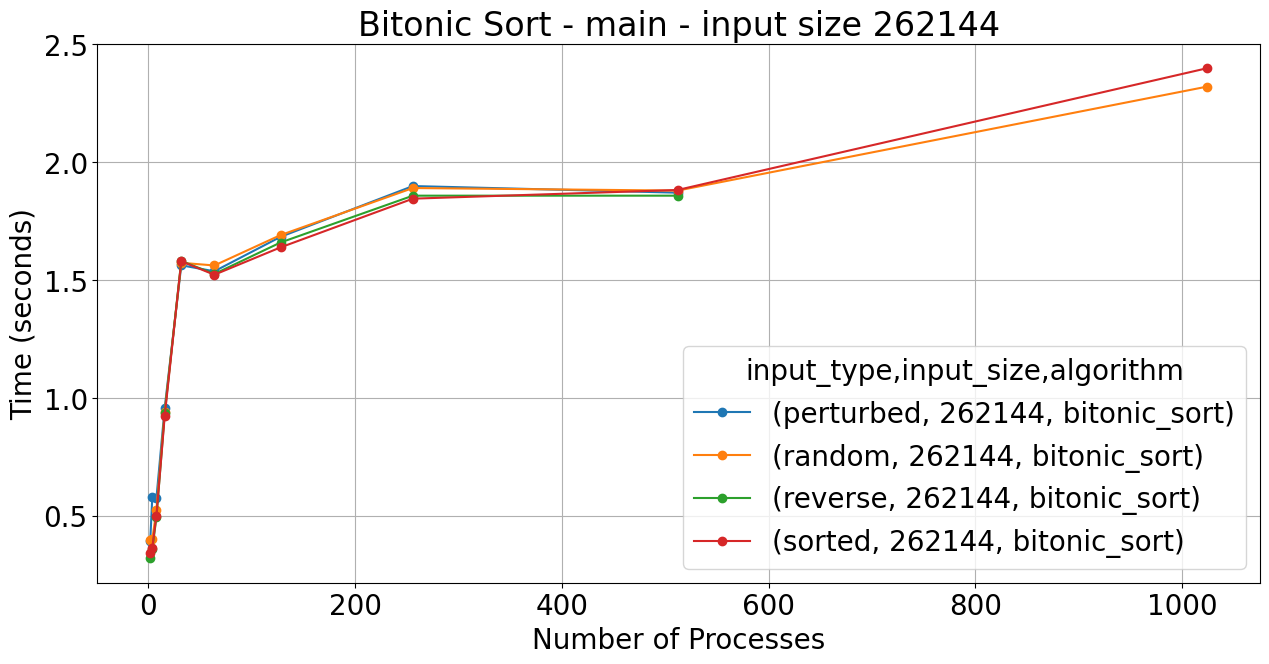

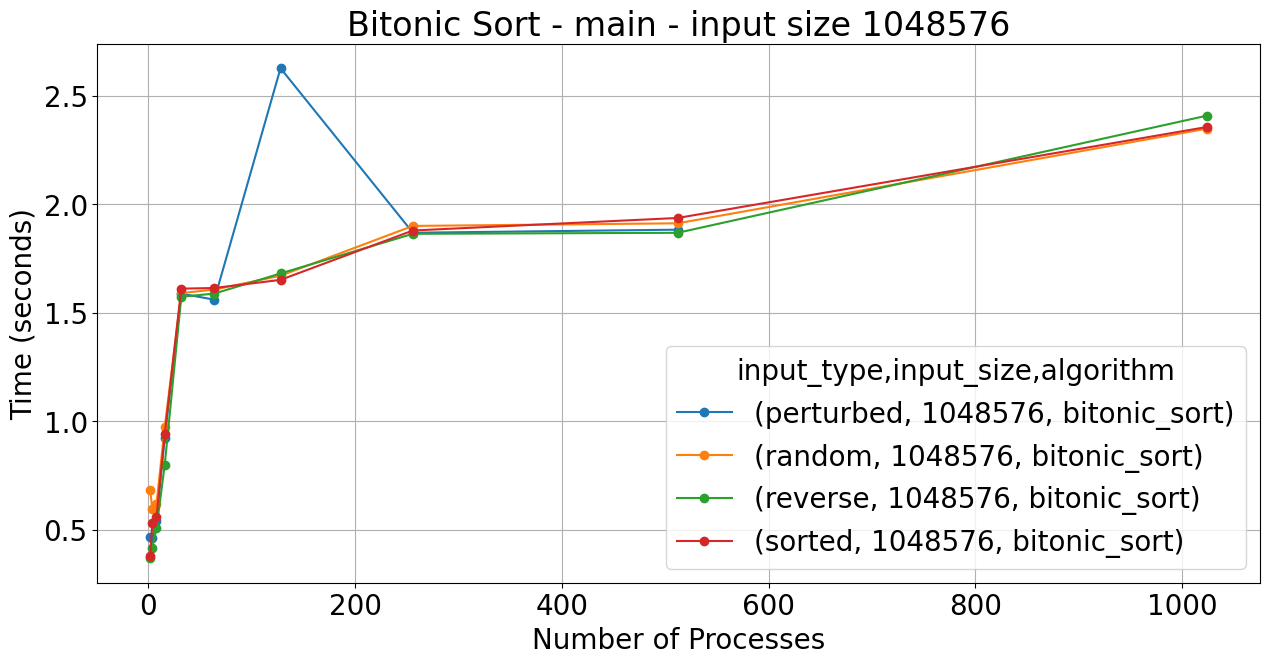

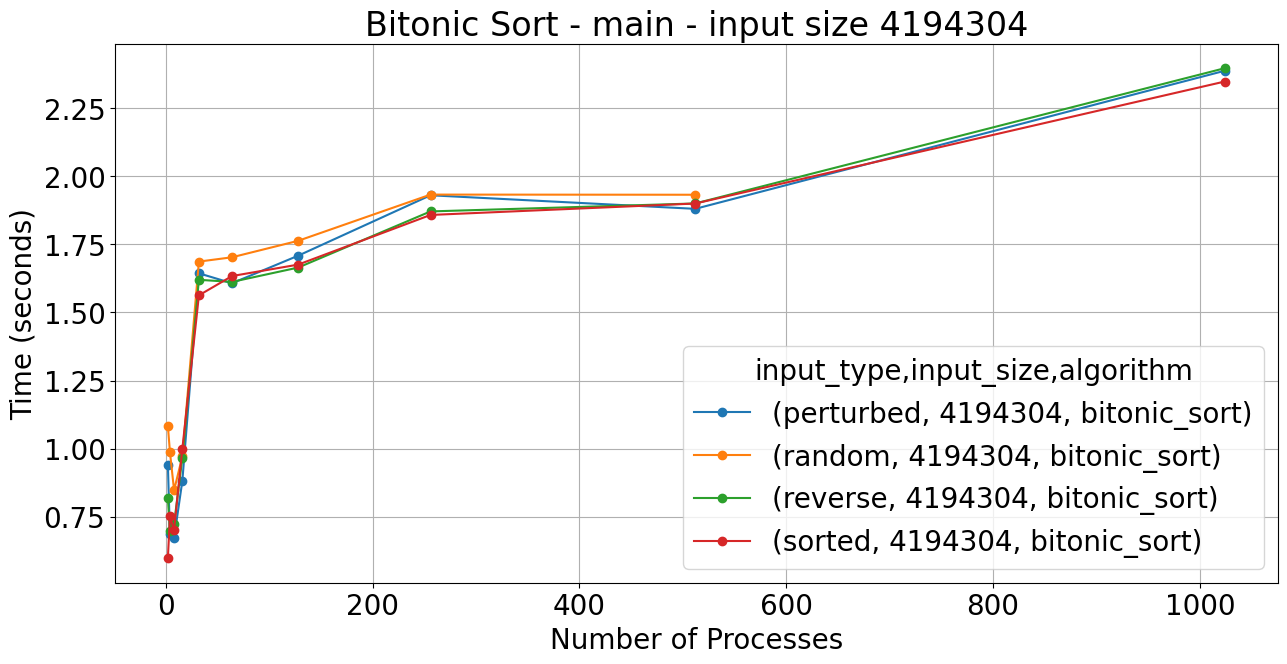

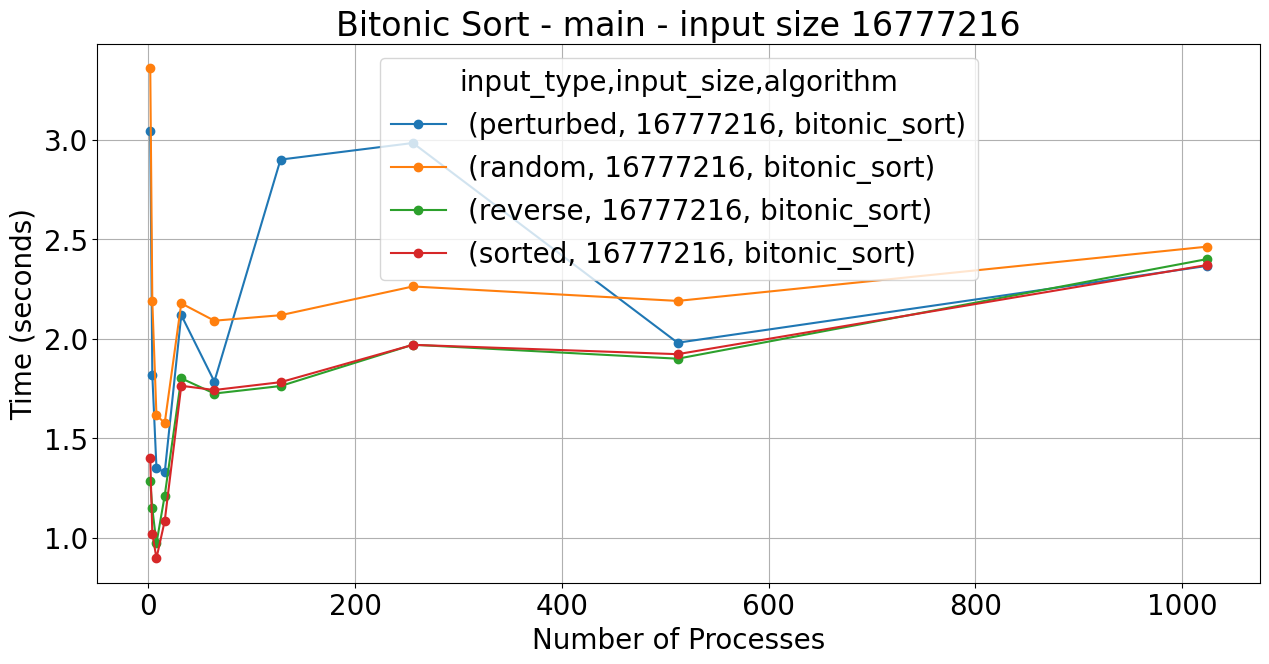

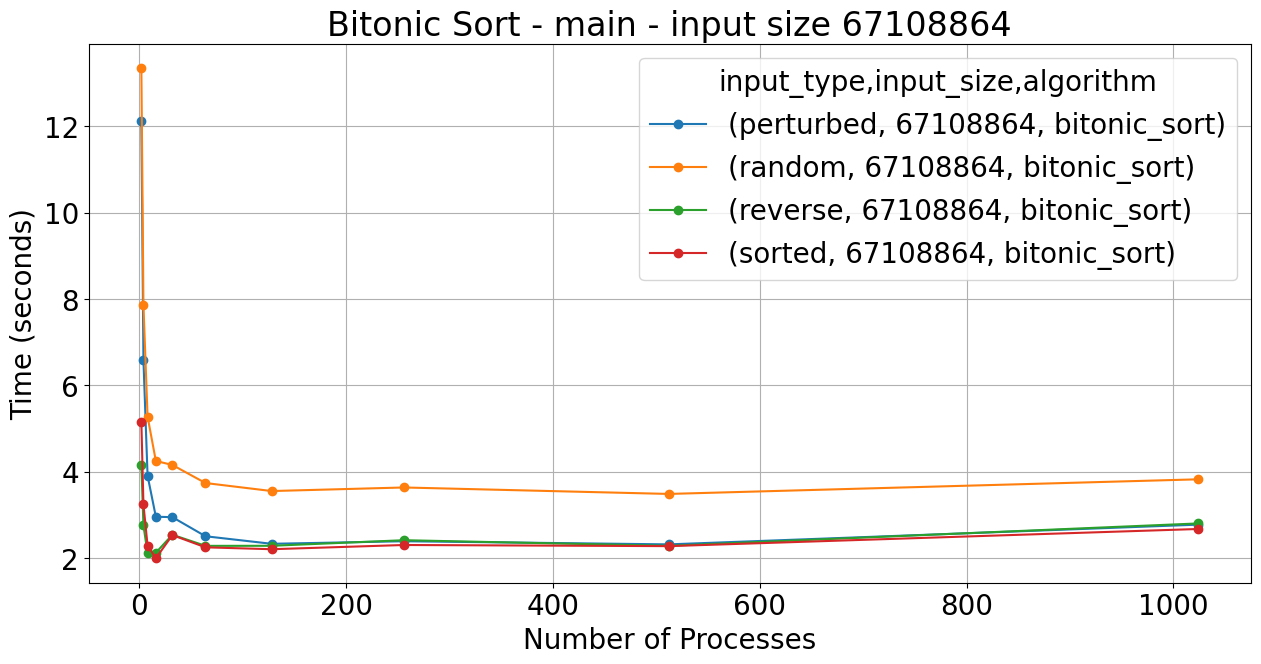

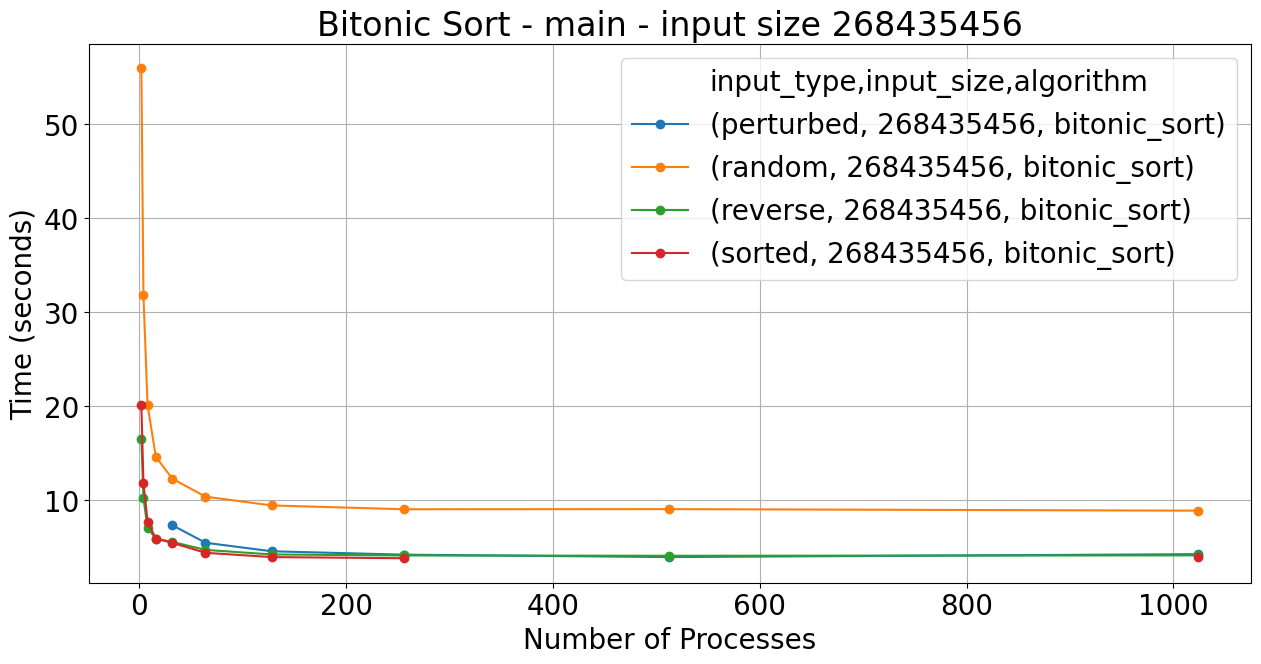

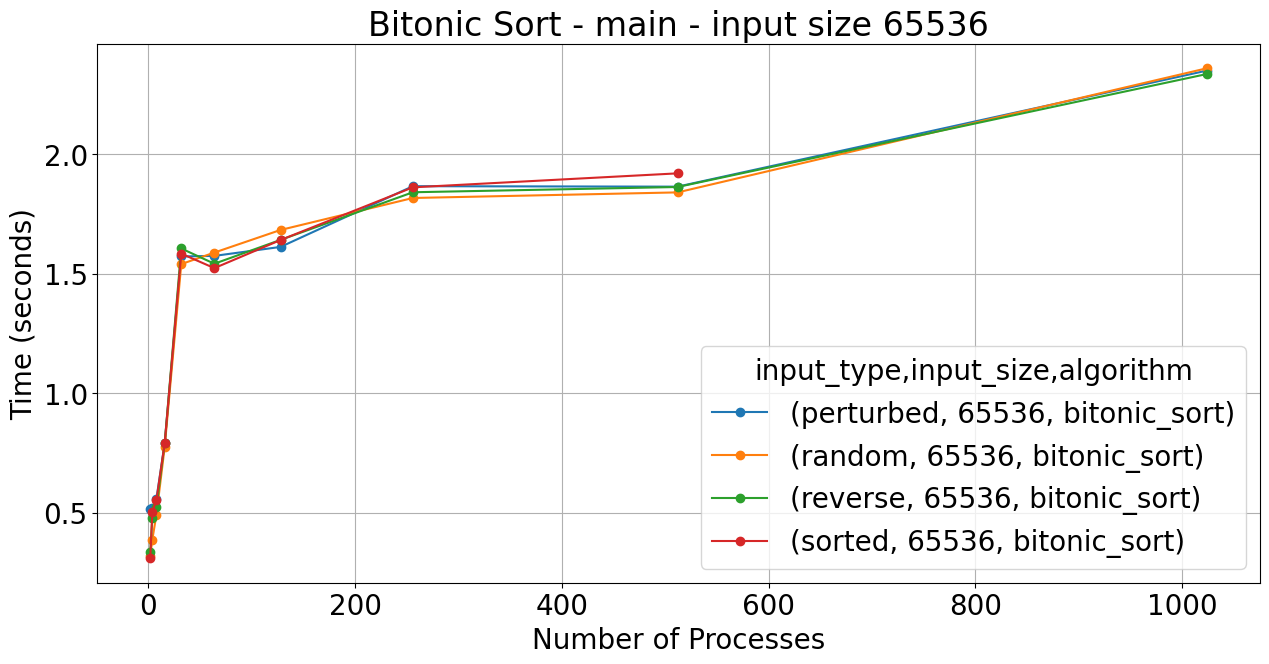

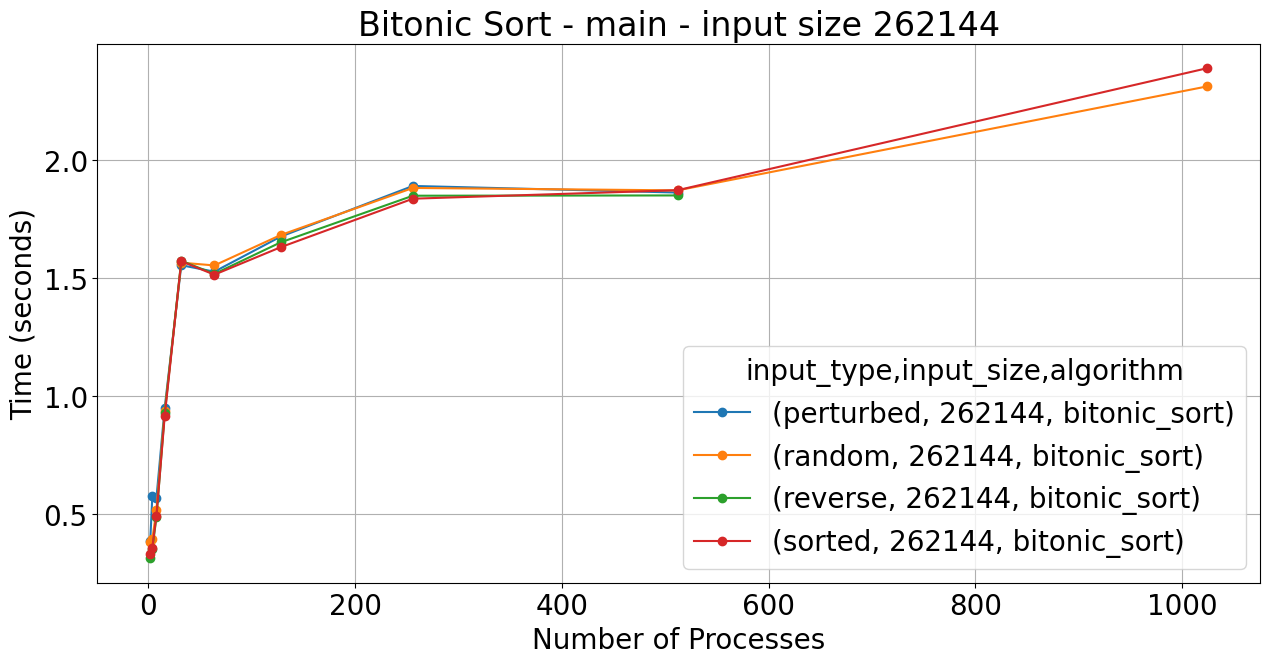

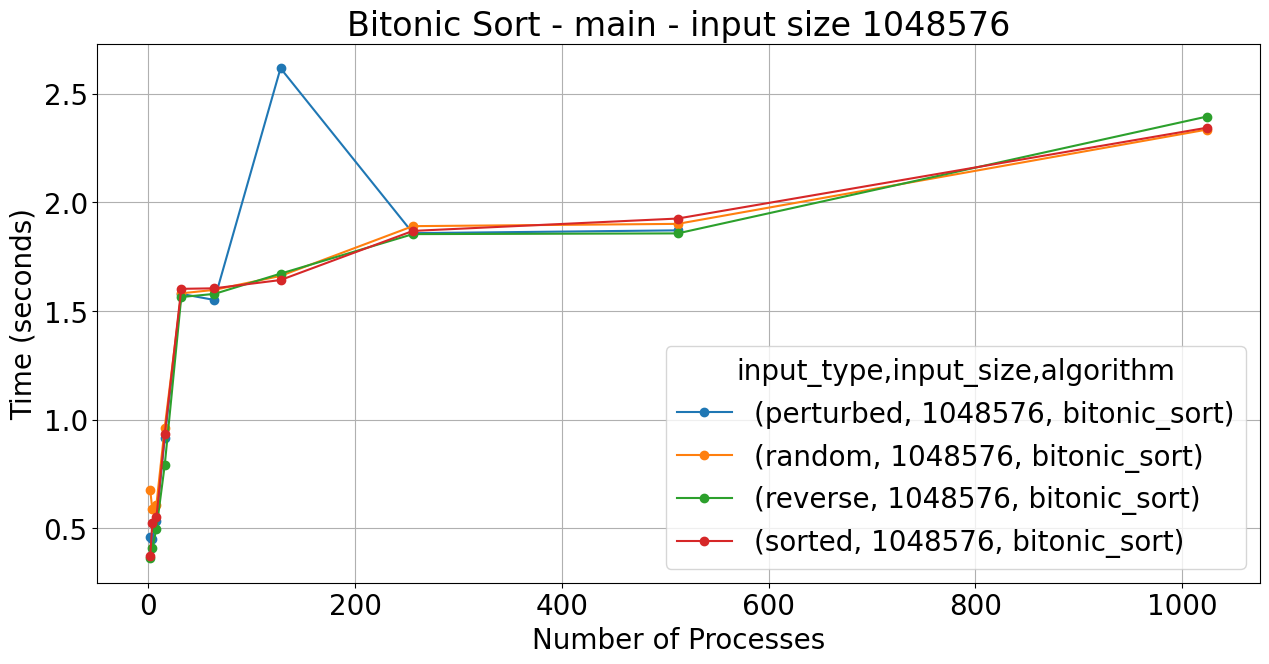

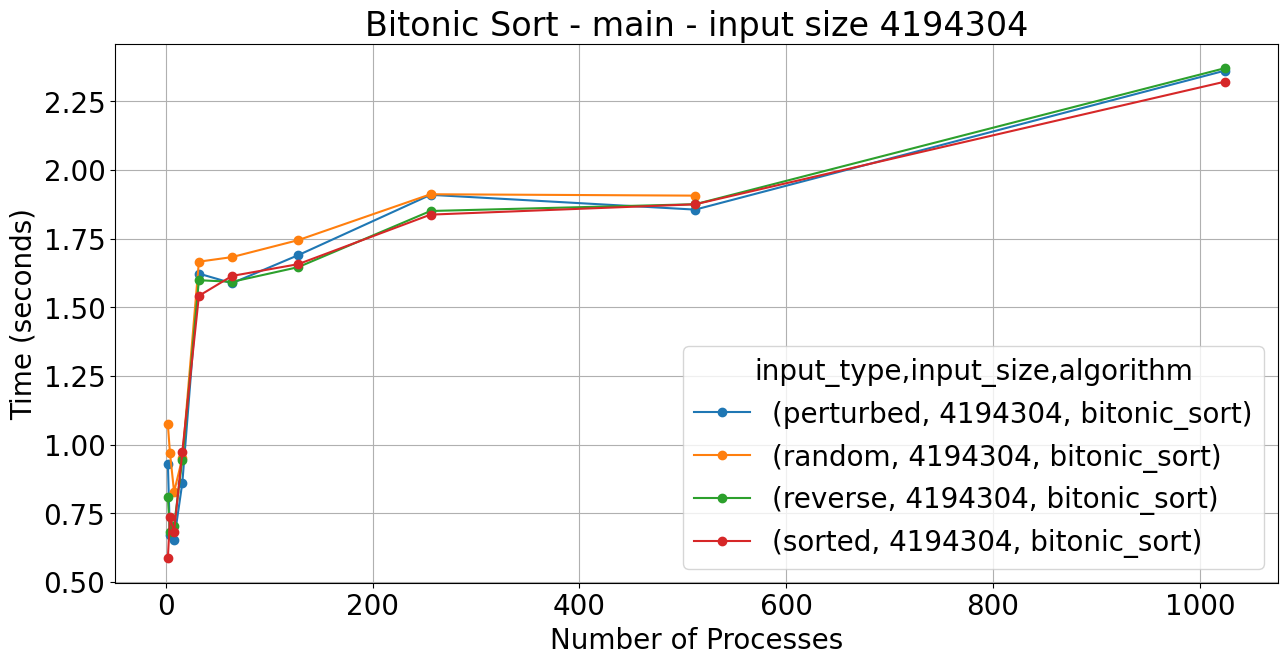

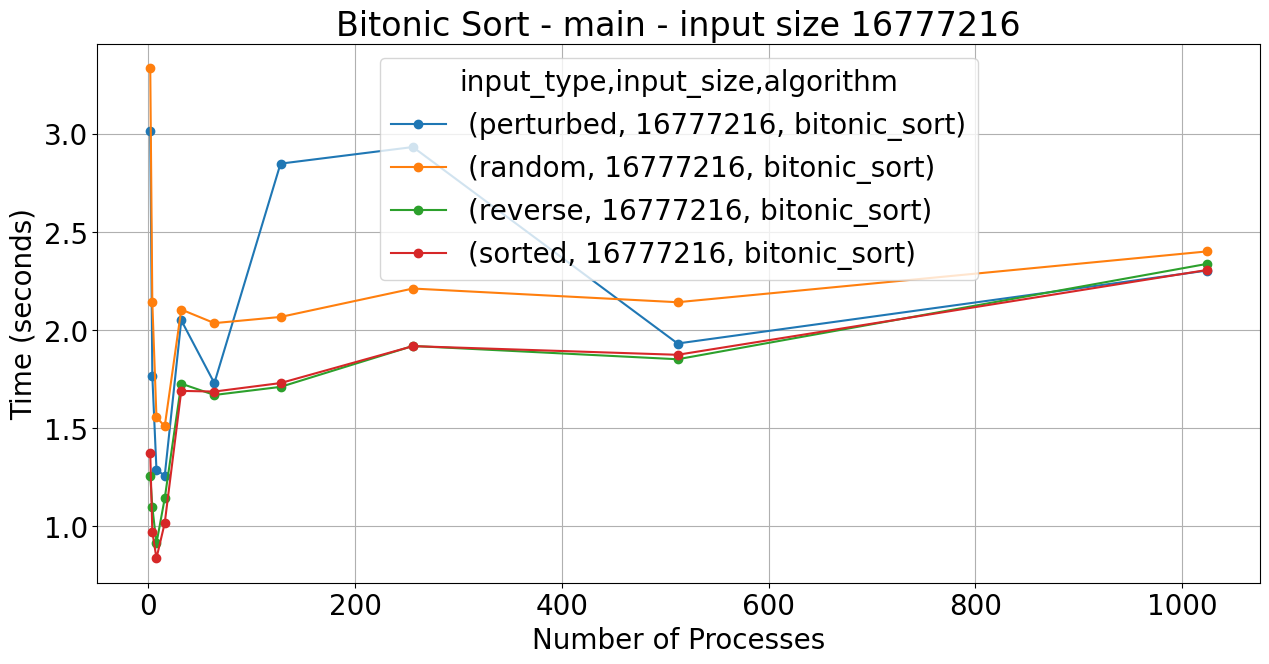

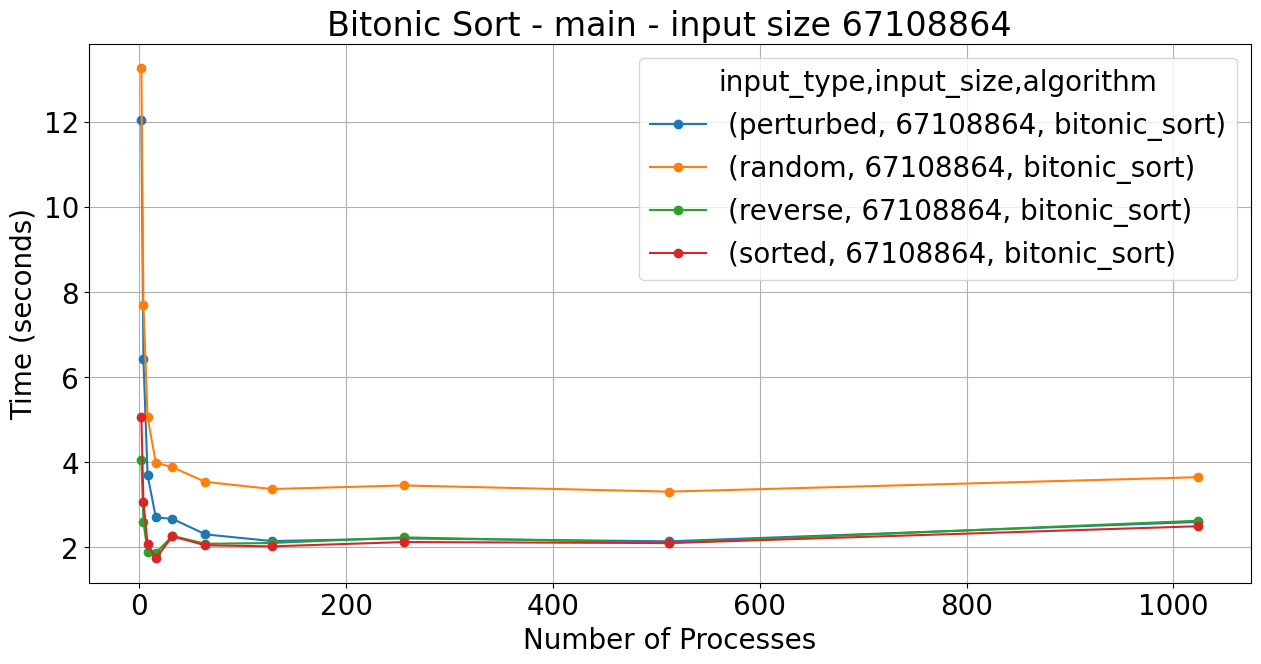

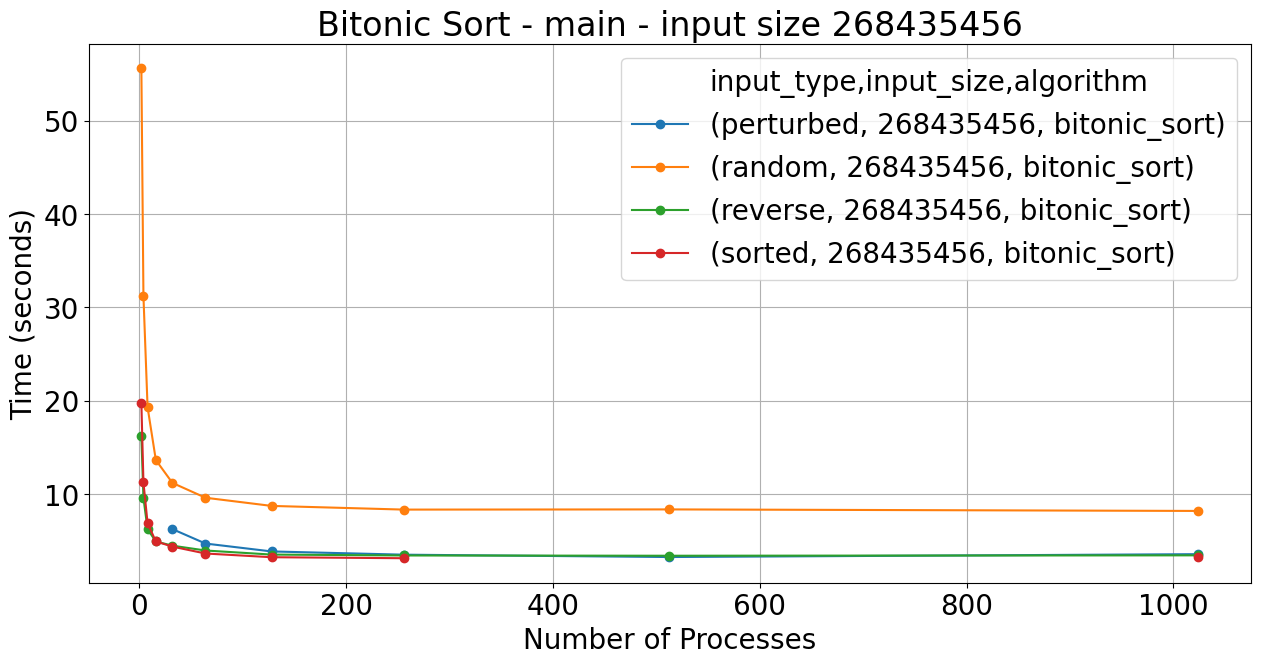

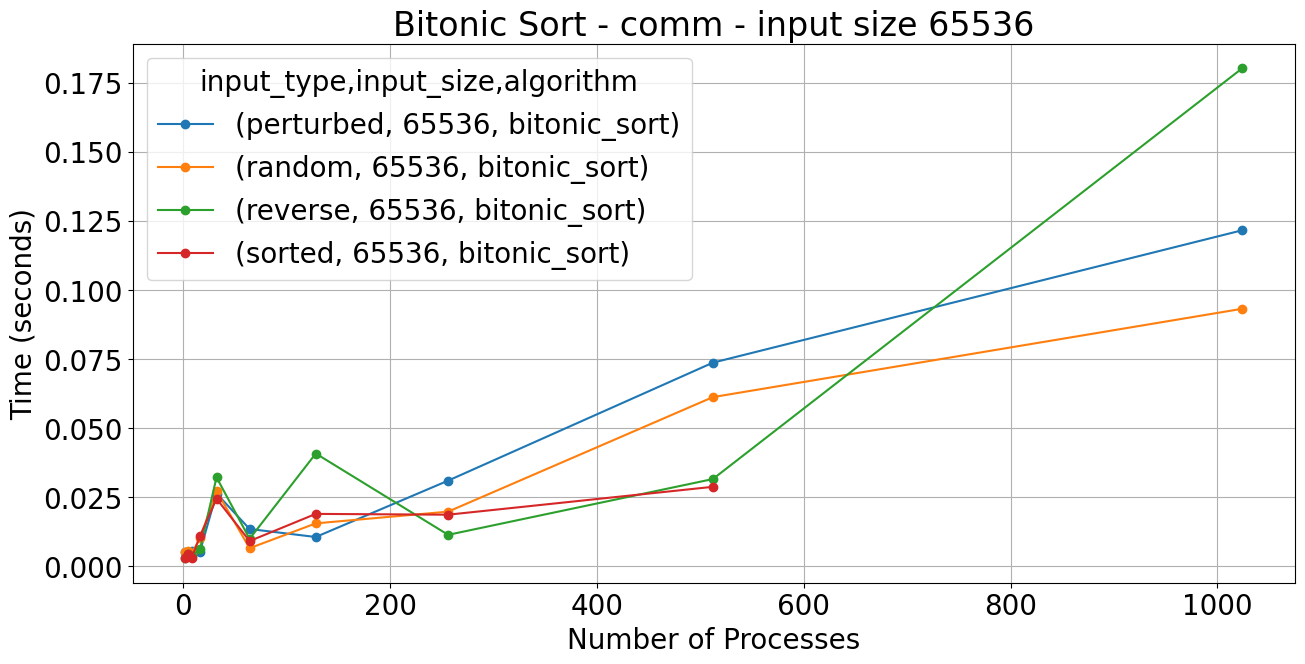

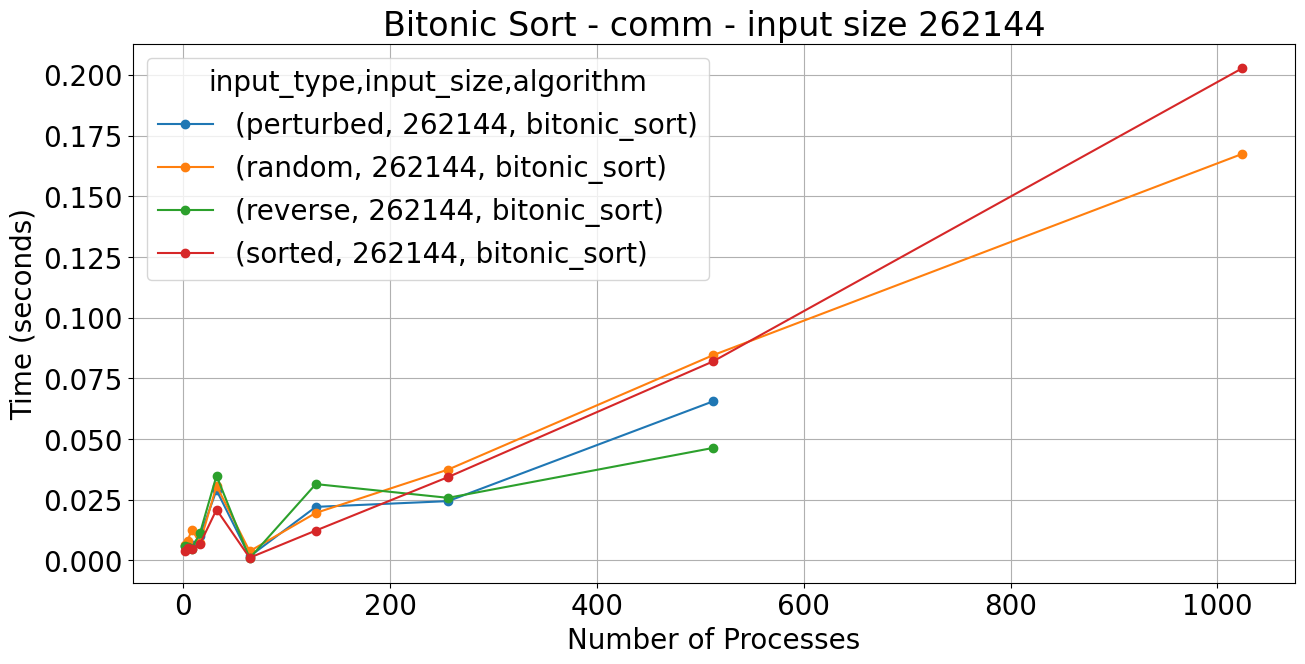

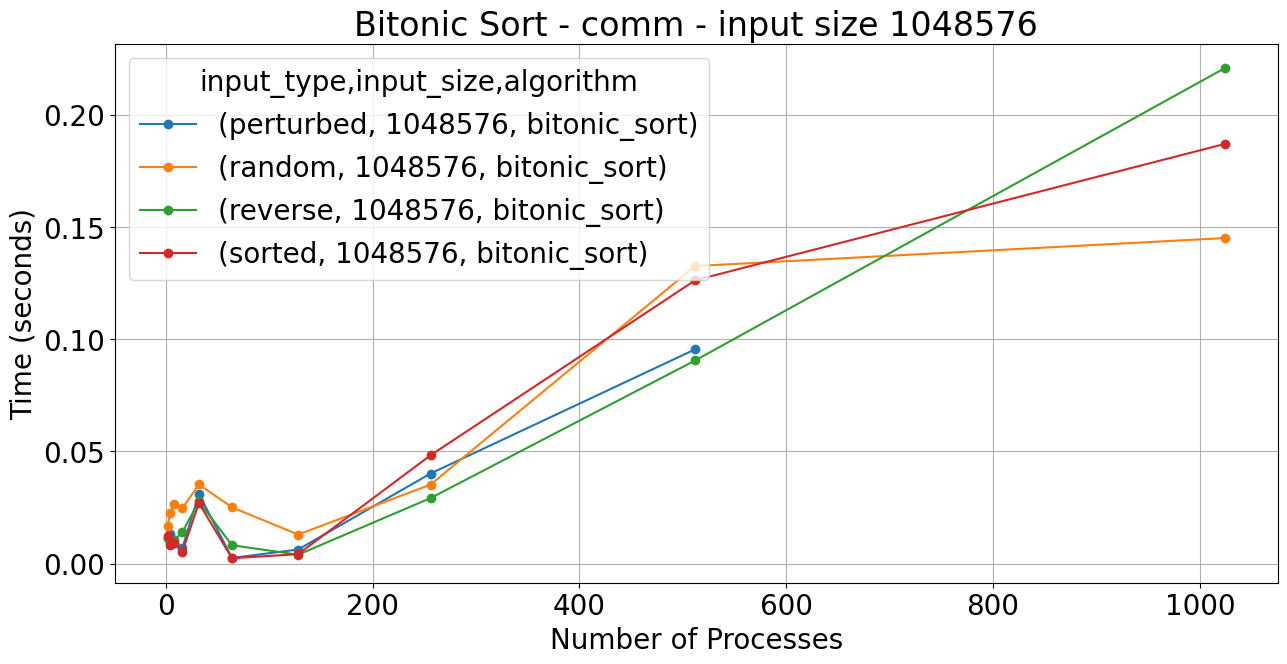

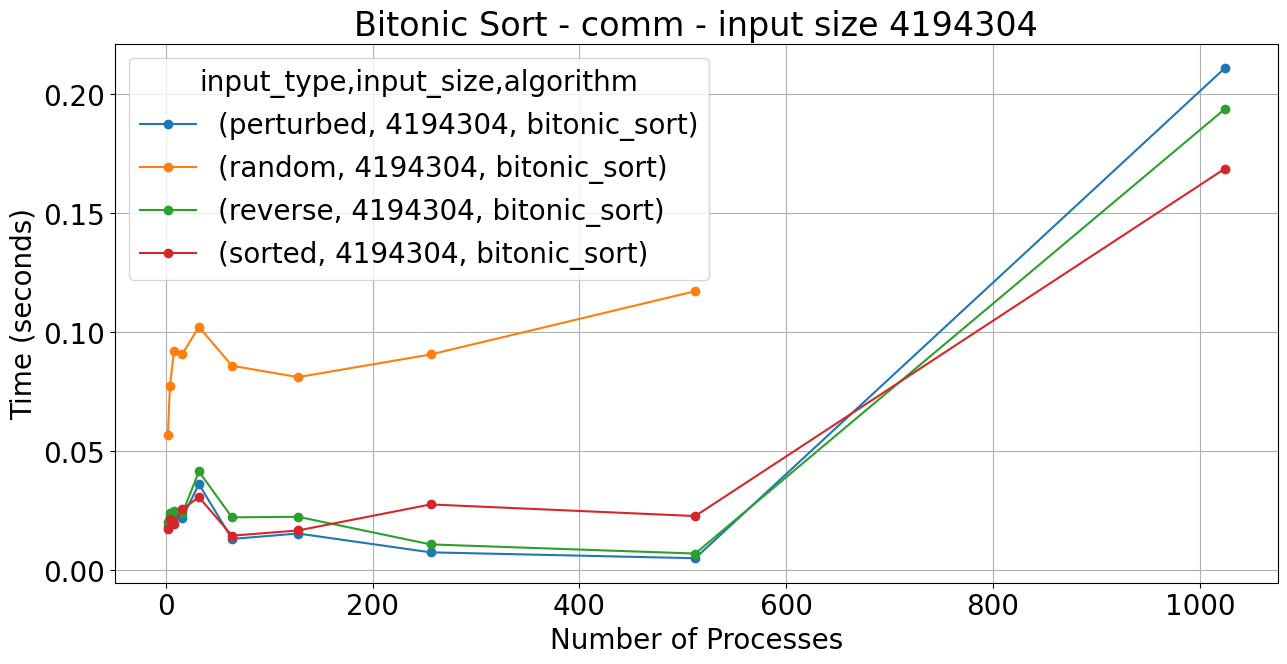

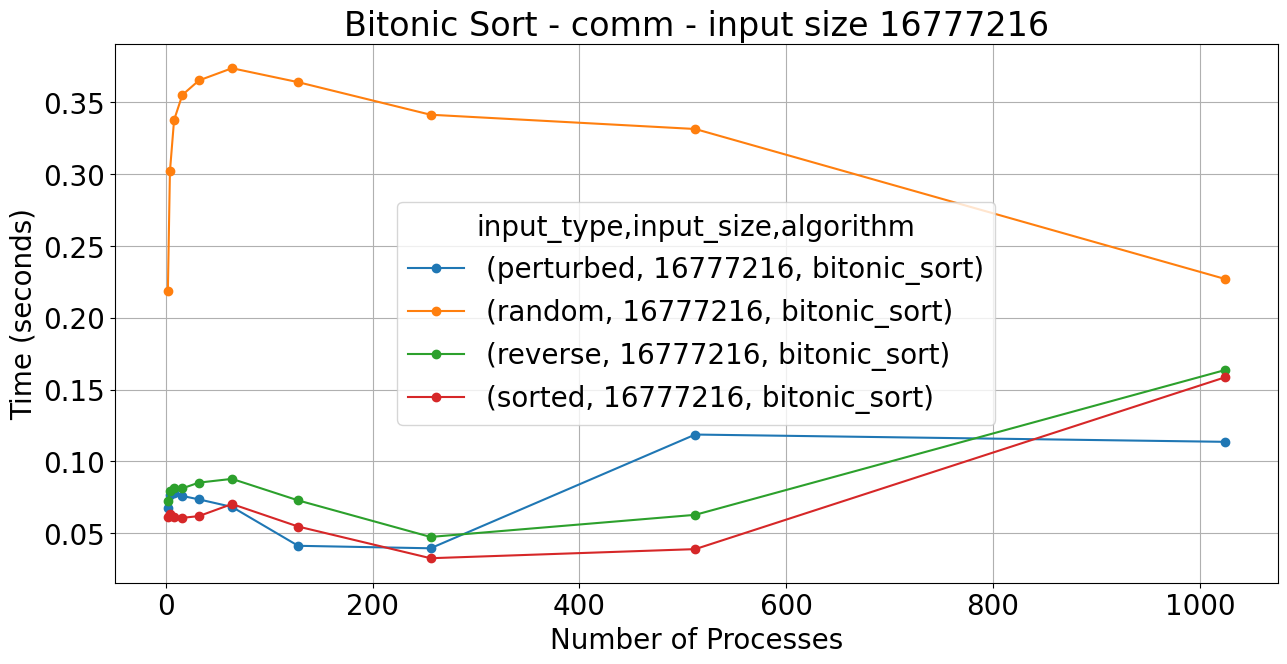

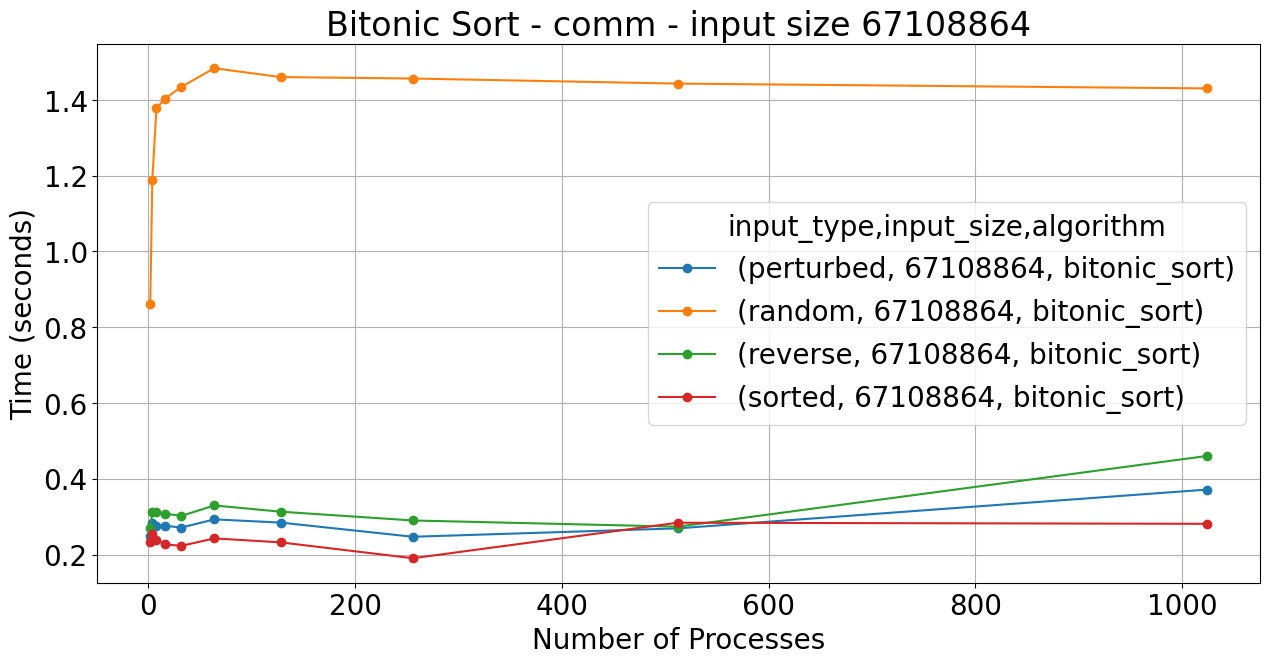

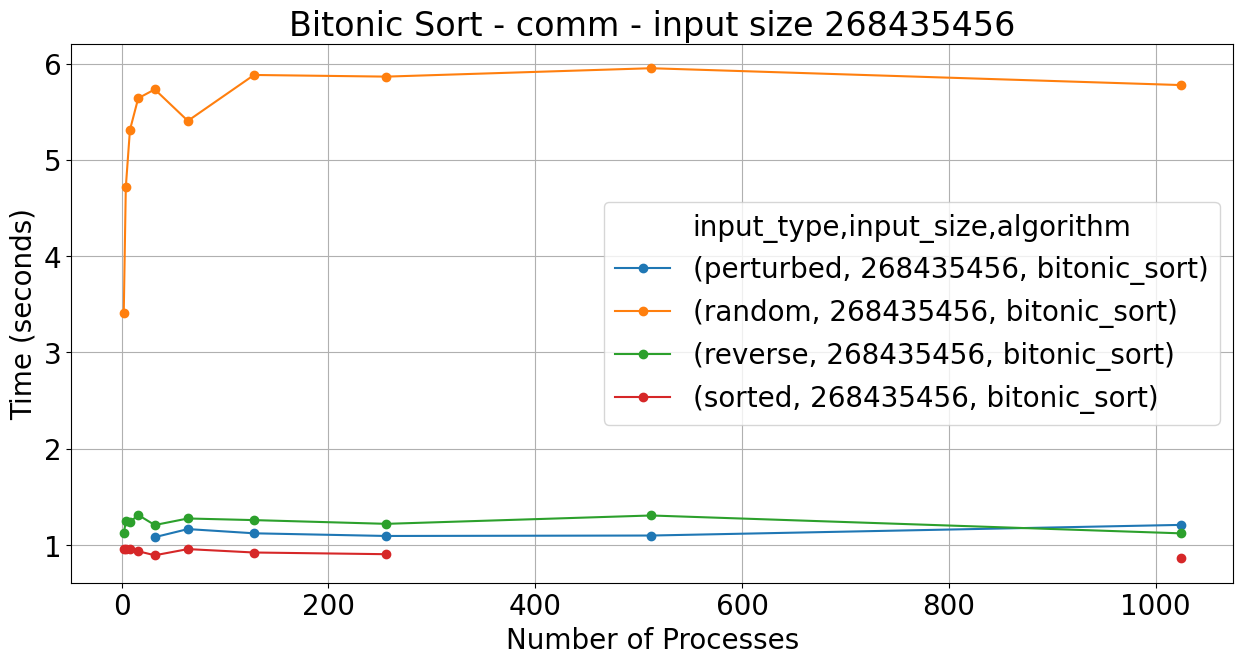

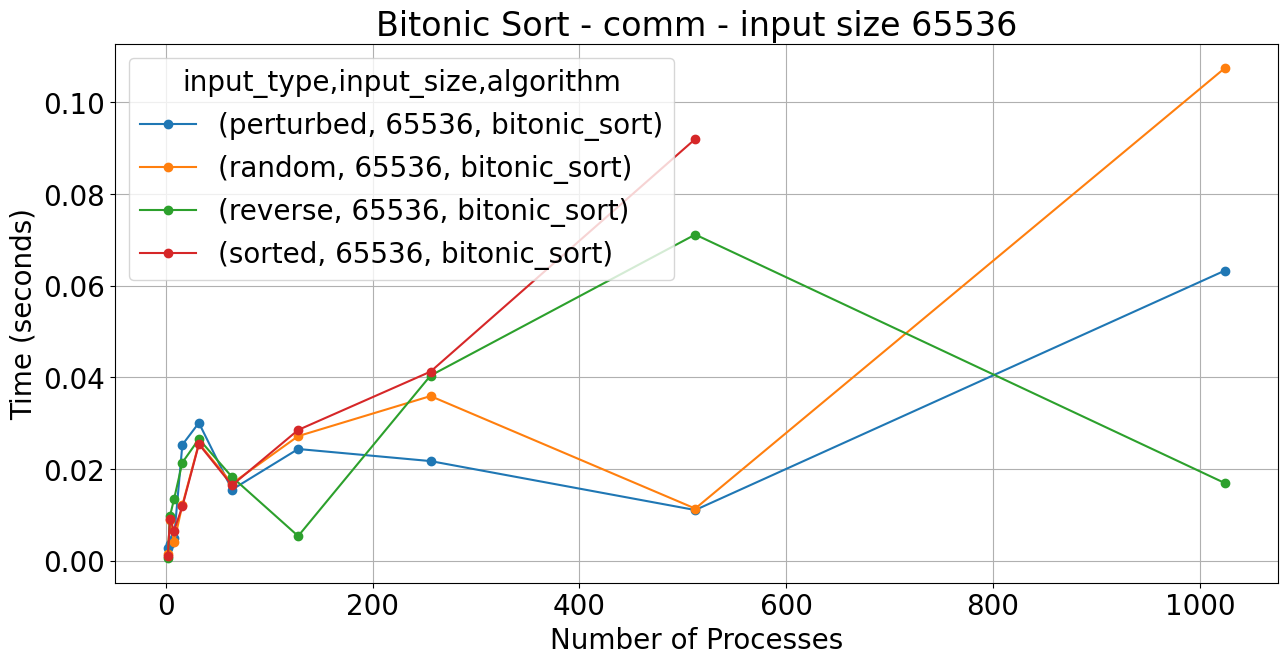

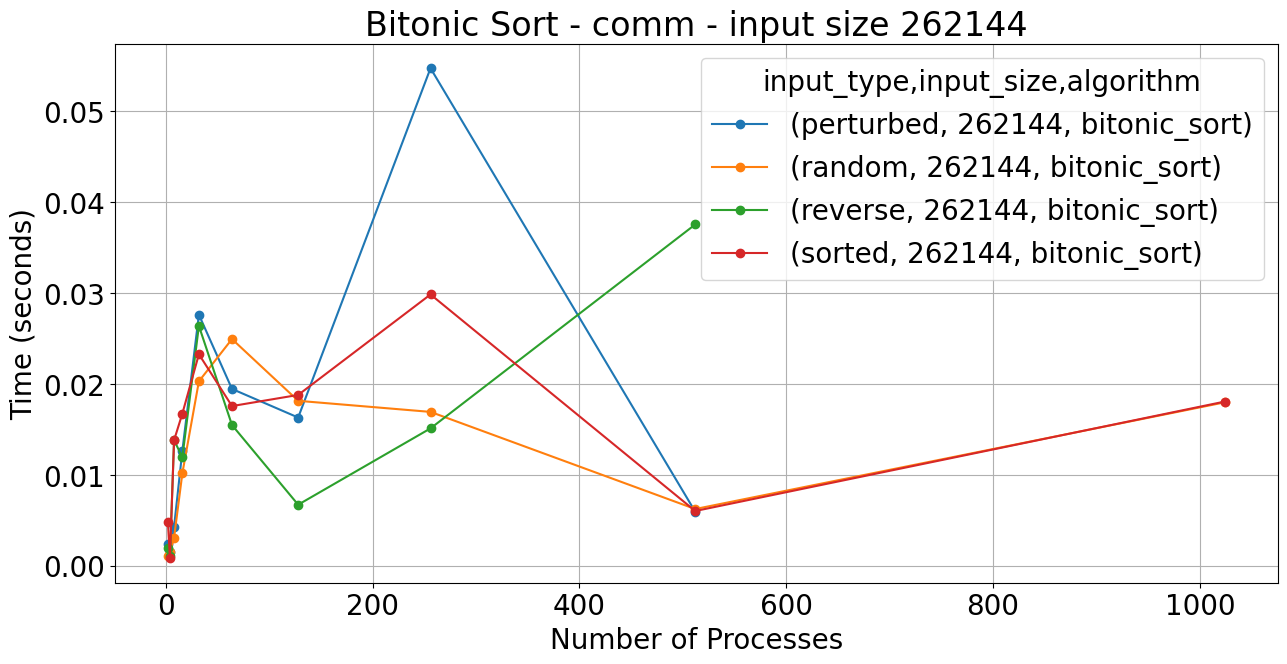

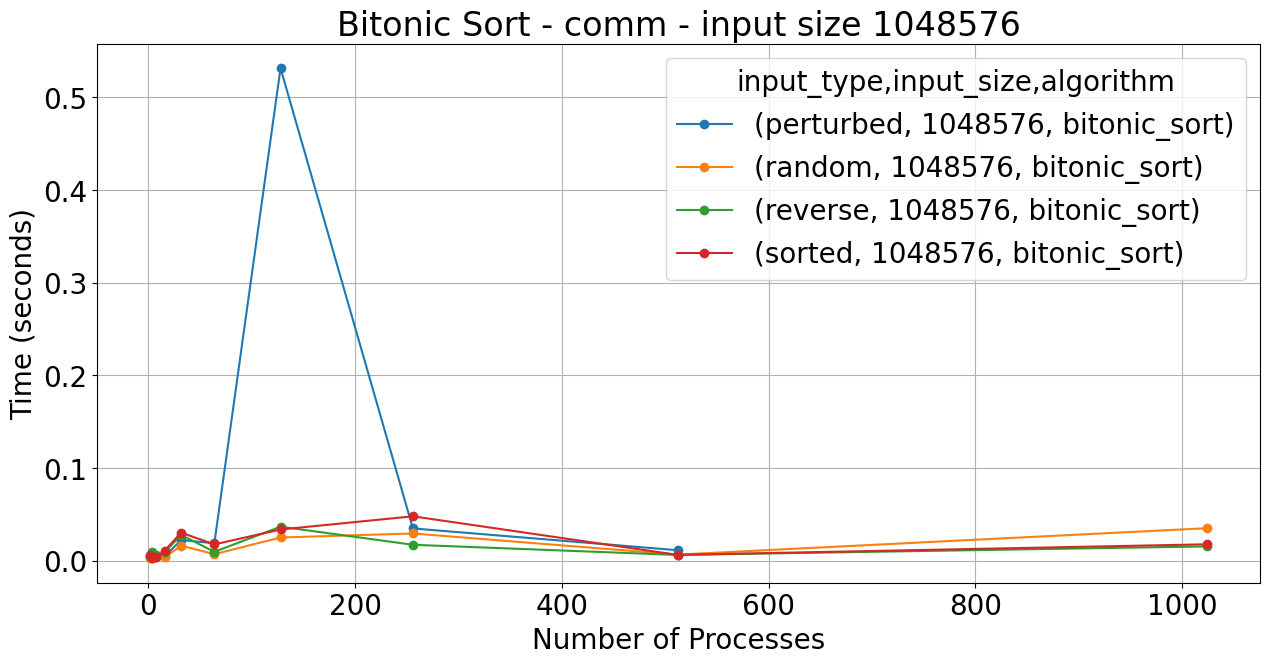

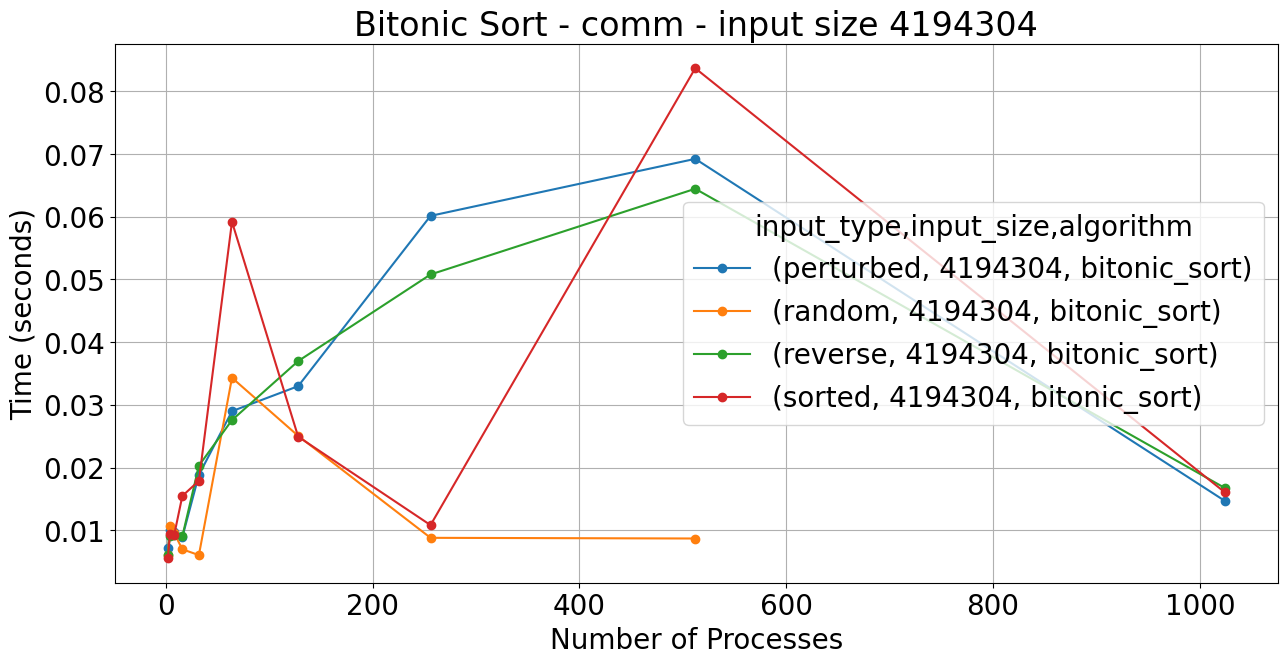

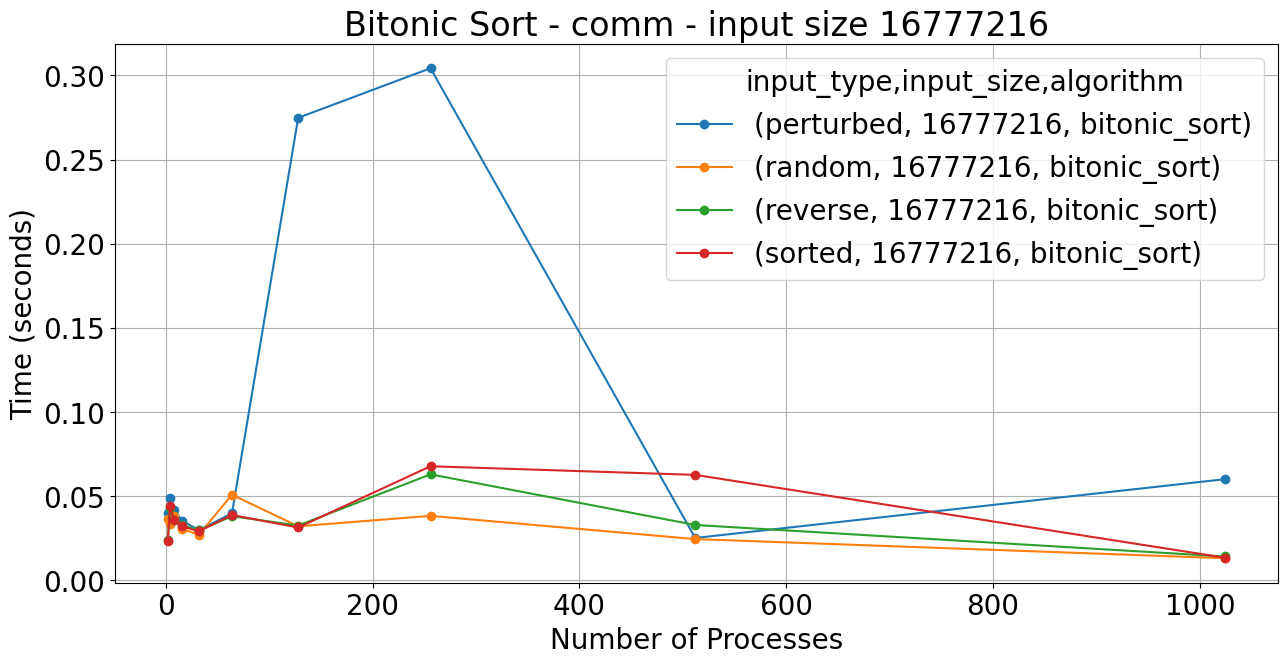

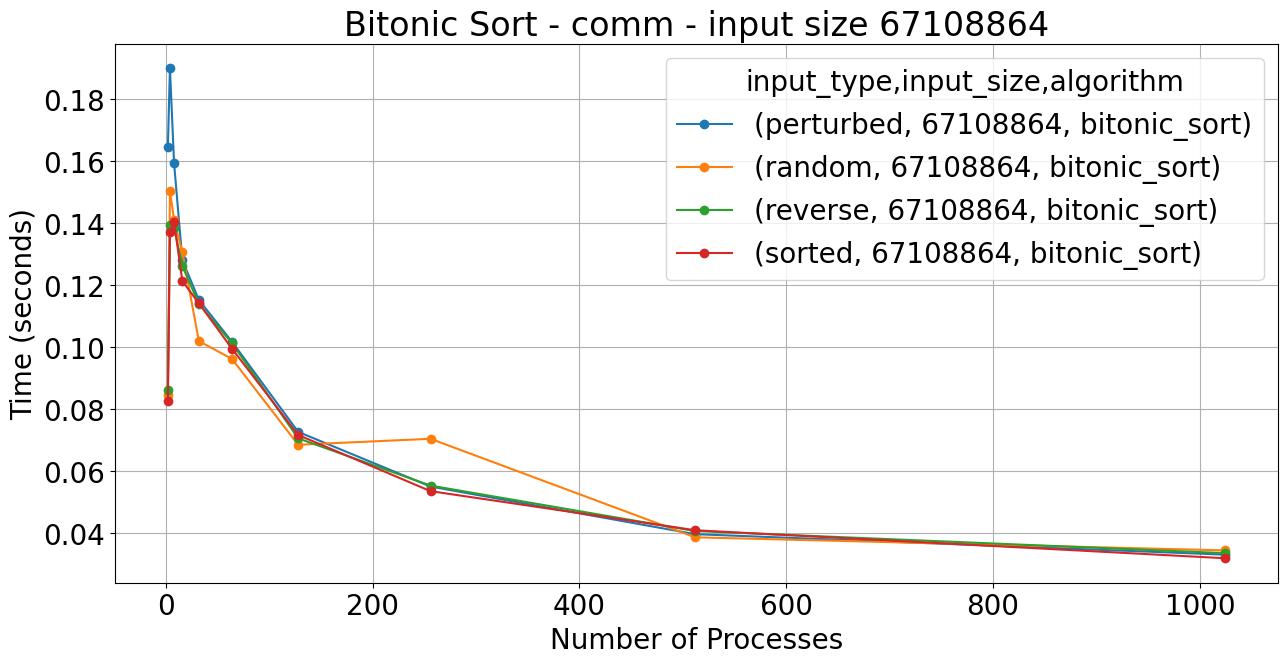

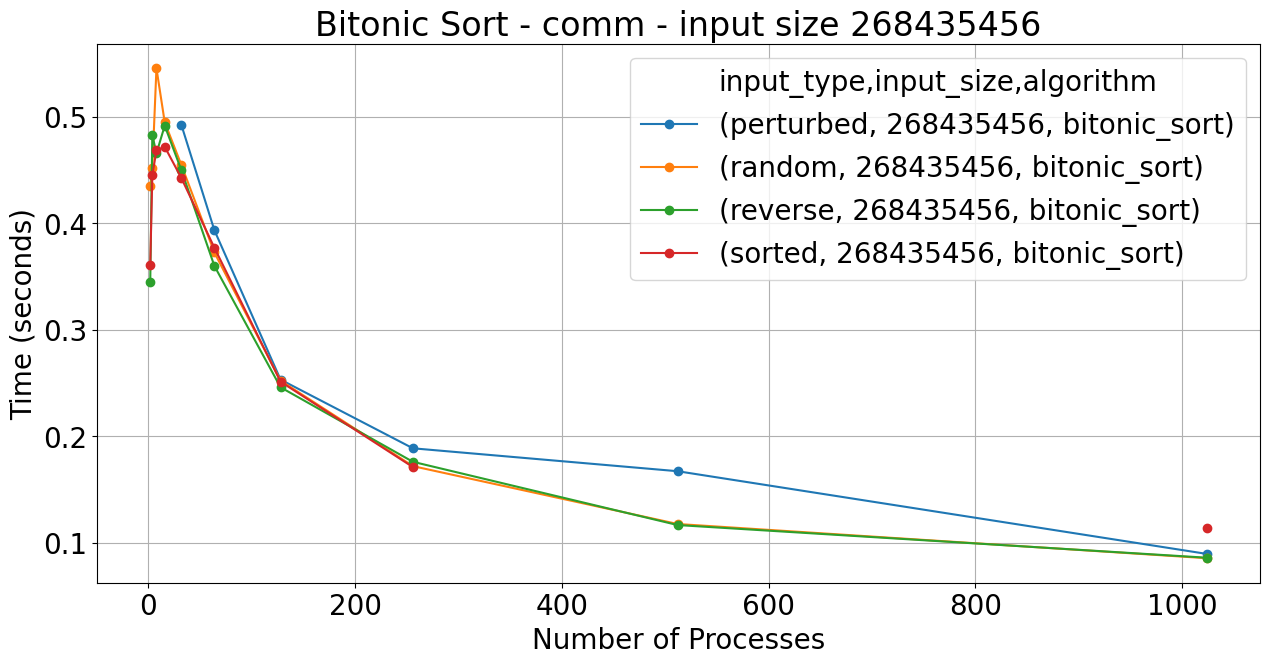

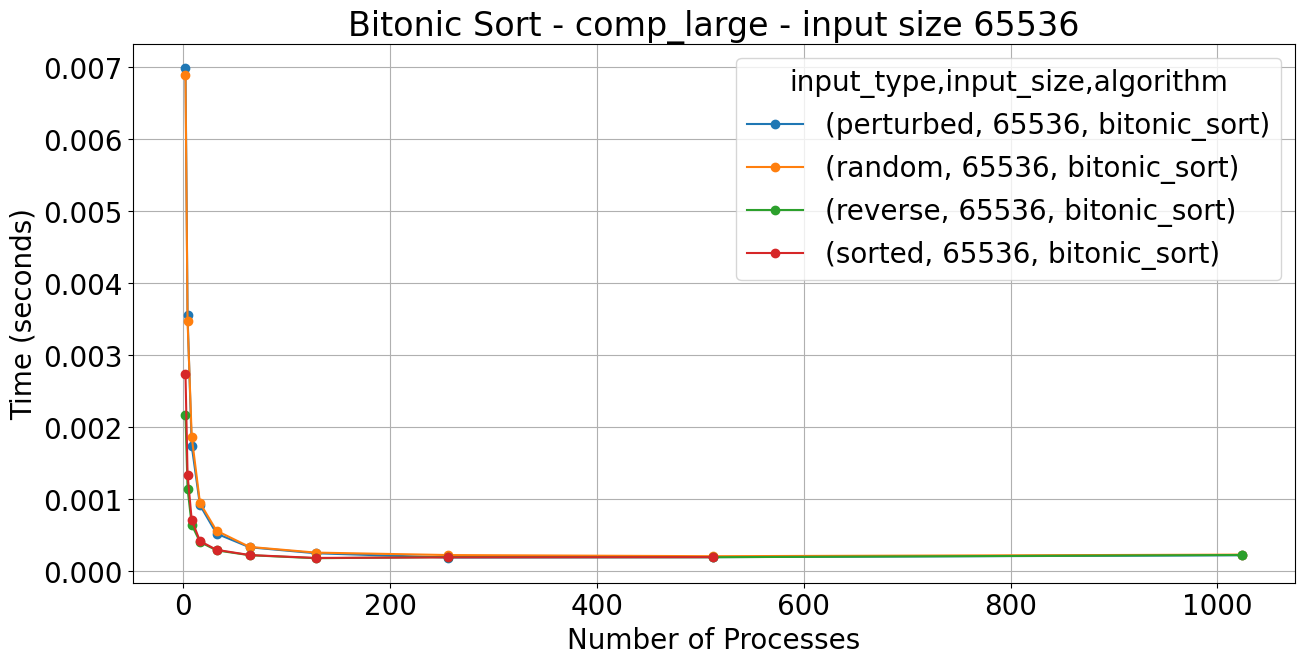

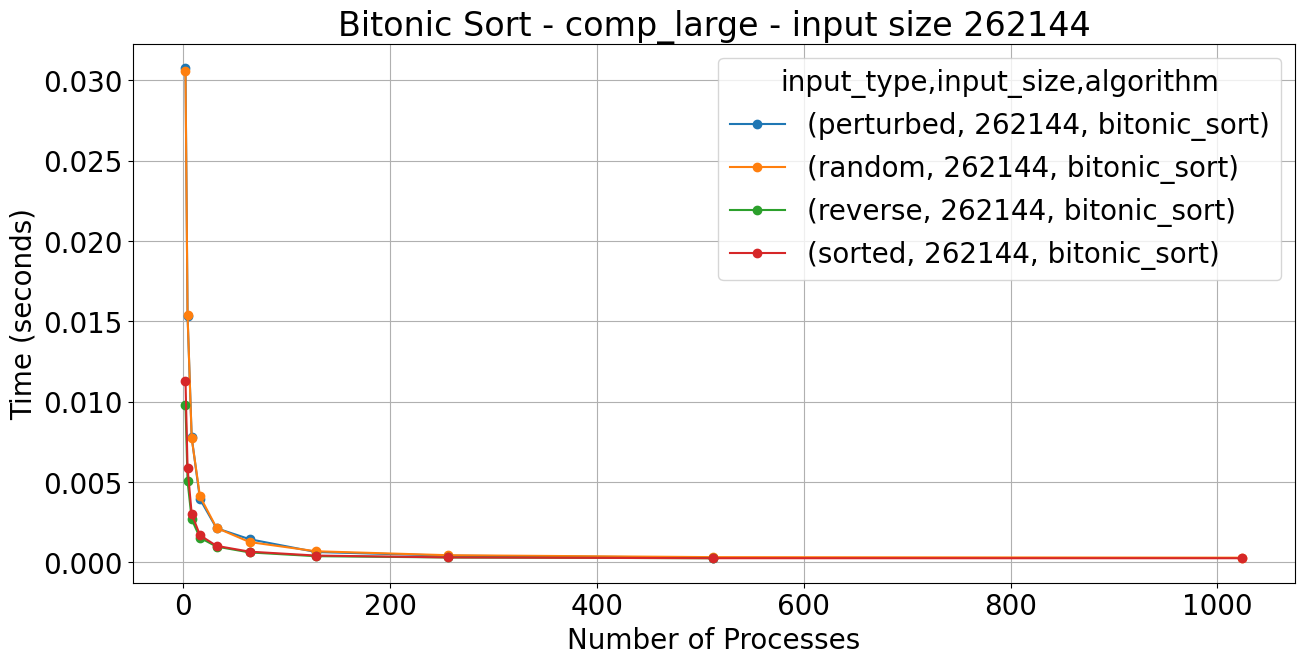

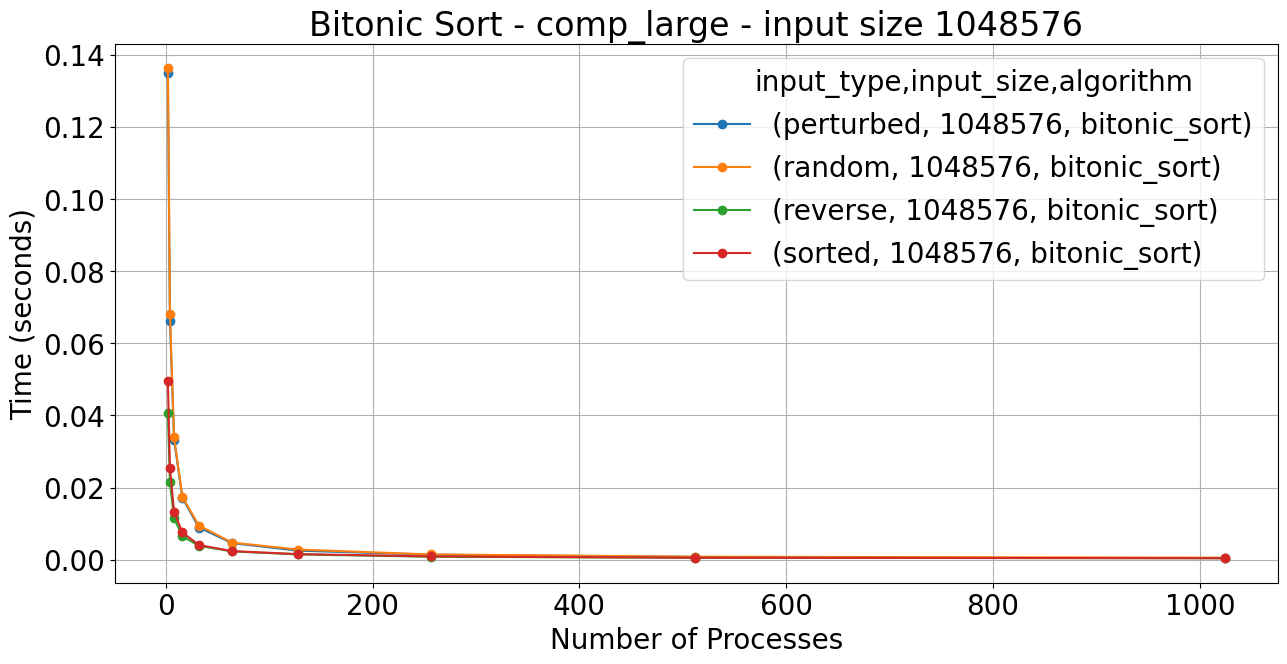

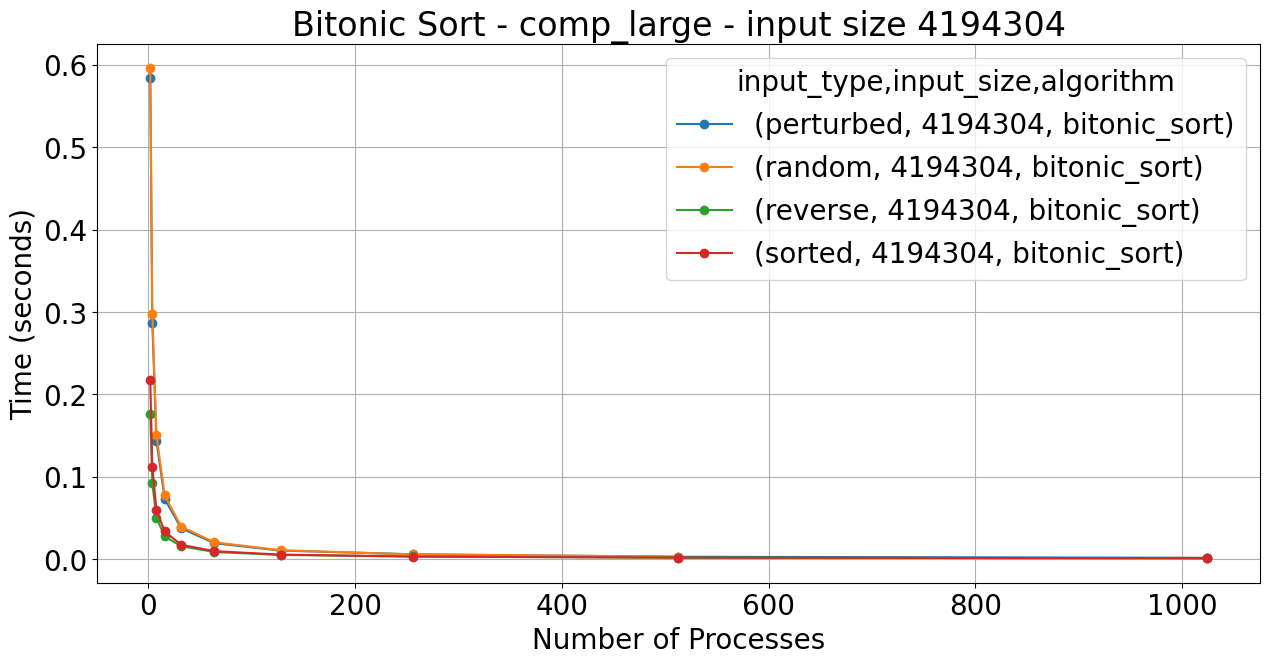

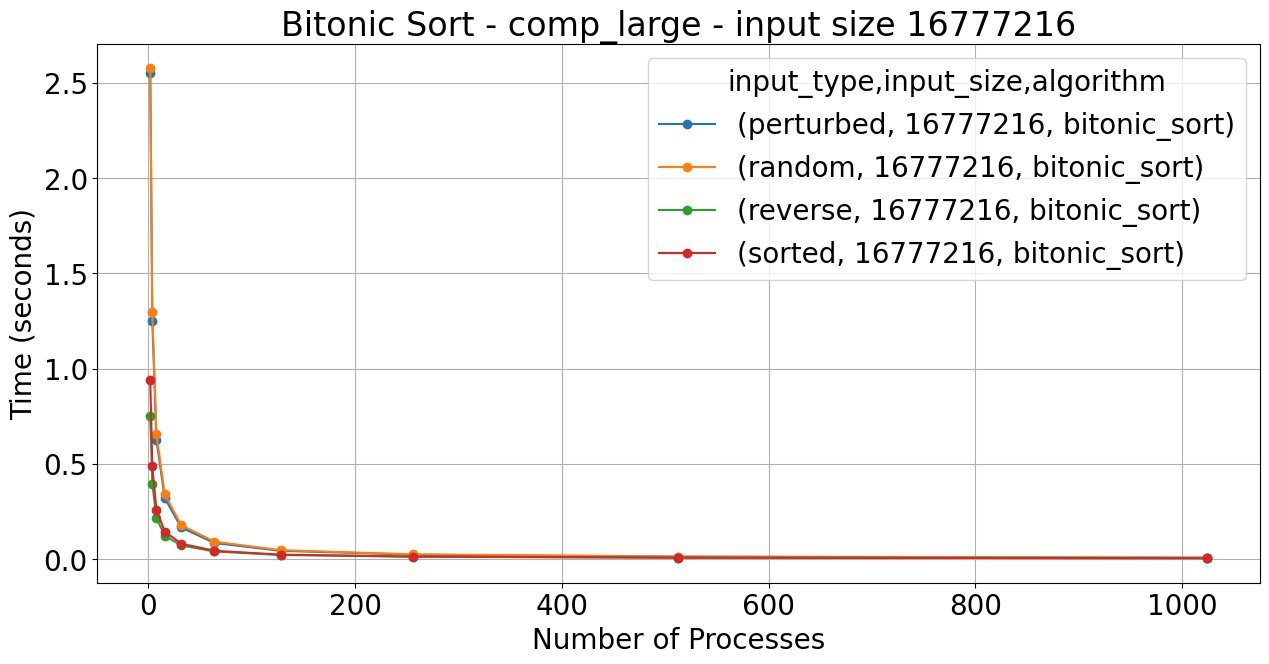

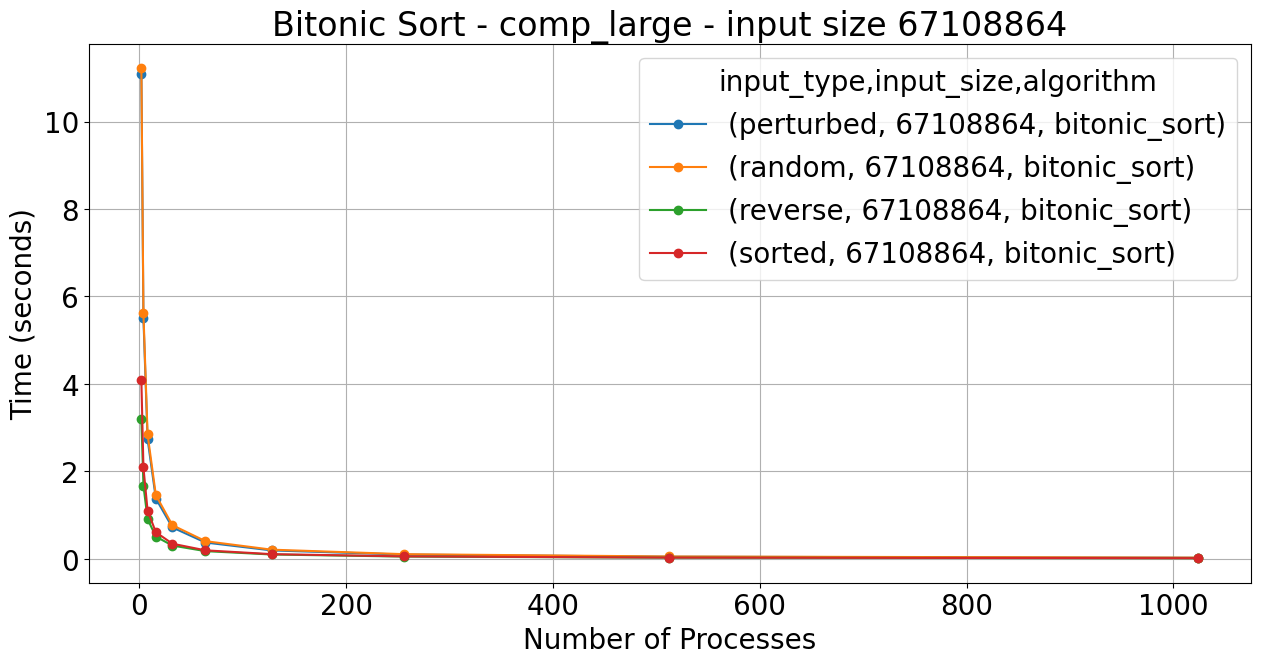

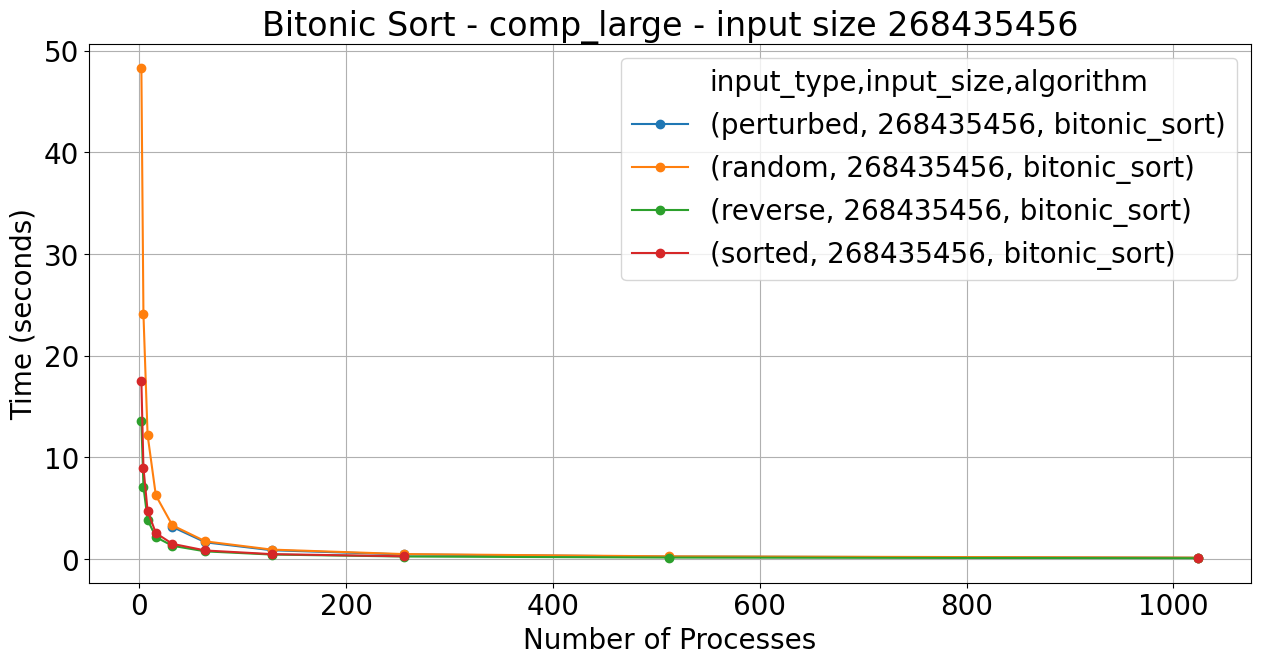

In [21]:
# graphs for main. comm, and comp_large
for node in tk.graph.traverse():
    if node.frame["name"] != 'main' and node.frame["name"] != 'comm' and node.frame["name"] != 'comp_large':
        continue
    for size in array_sizes:
        df=(tk.dataframe.loc[node, "Avg time/rank"])
        df = (df.loc[df.index.get_level_values('input_size') == size])
        df = df.unstack(level="input_type")
        df = df.unstack(level="input_size")
        df = df.unstack(level="algorithm")
        plot_pandas(
            df,
            title="Bitonic Sort - " + str(node.frame["name"])+" - input size "+str(size),
            xlabel="Number of Processes",
            ylabel="Time (seconds)",
        )

        # automatically save graph as a file
        filename = f"./graphs/Bitonic_{str(node.frame['name'])}_{str(size)}.png"
        plt.savefig(filename)  # Save the plot as a PNG file

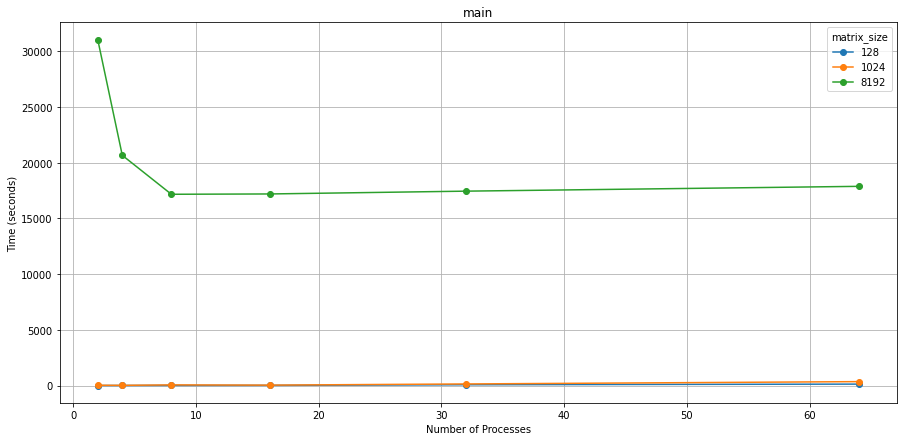

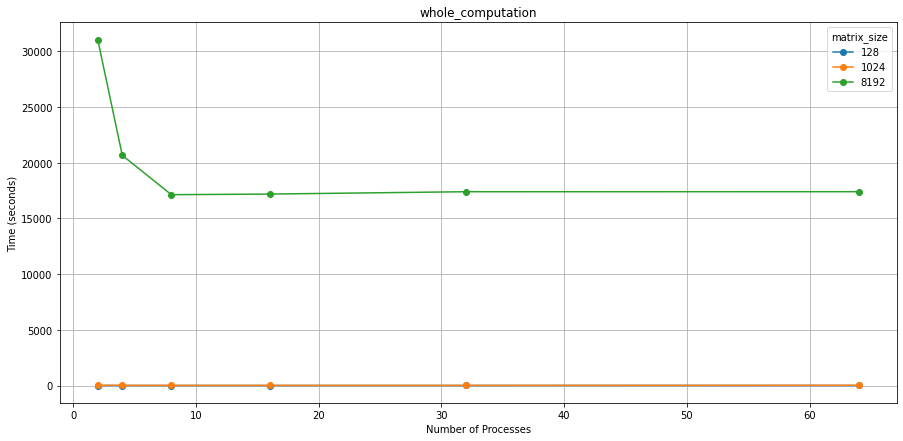

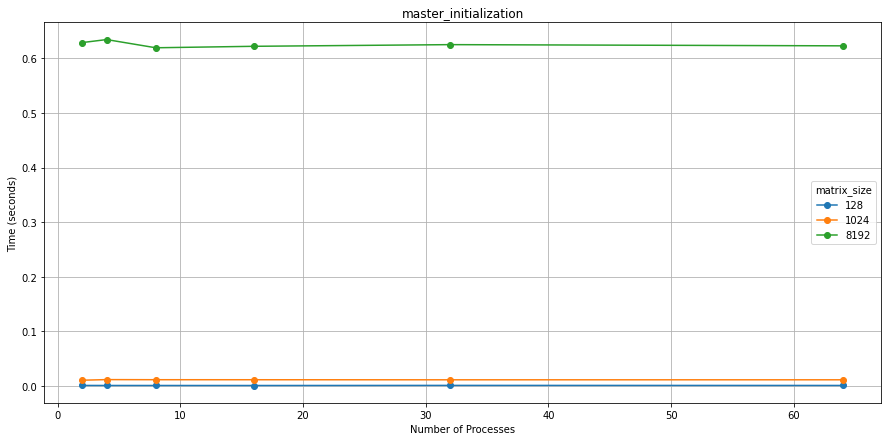

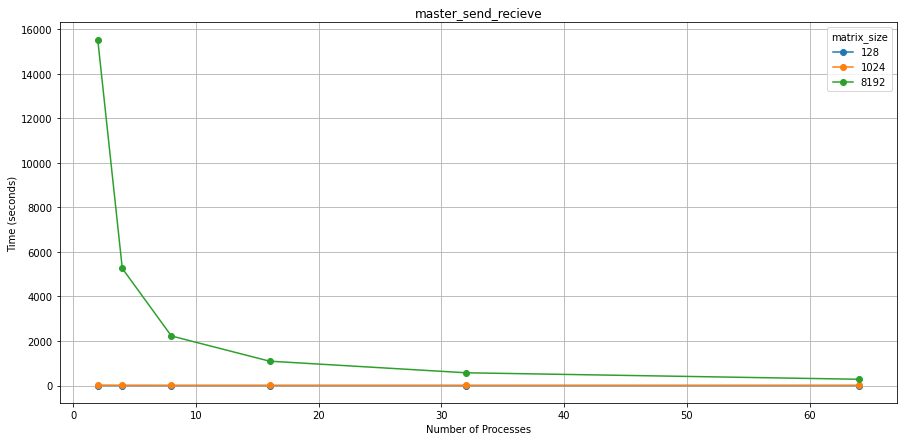

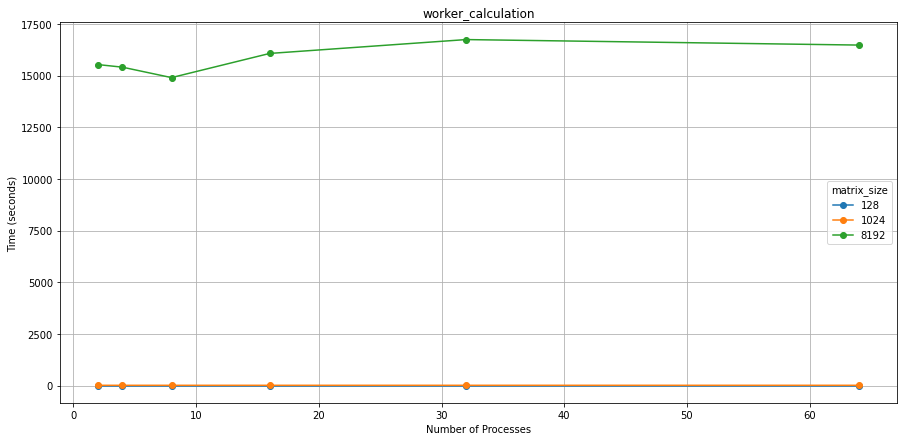

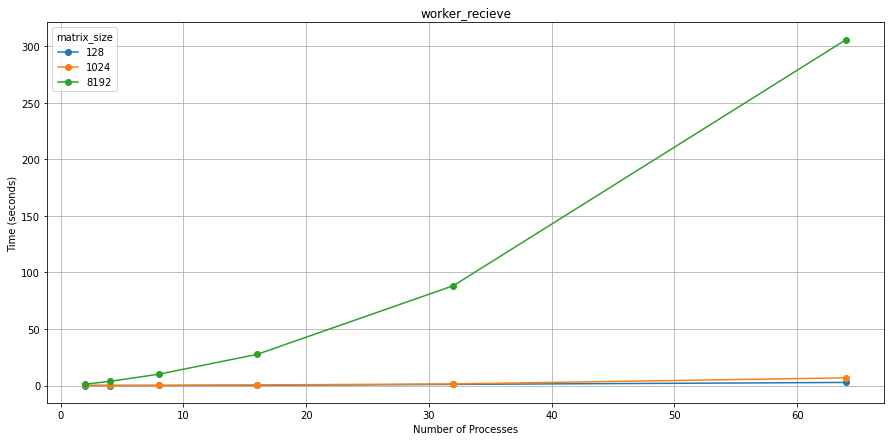

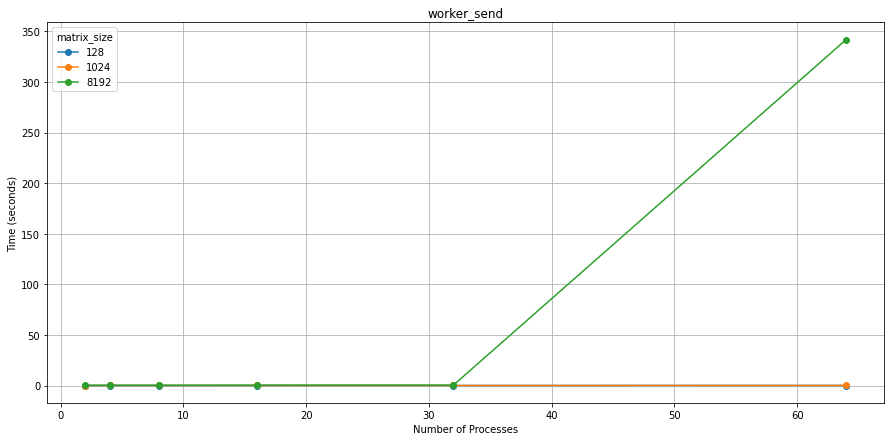

In [38]:
# From starter code, mainly used for master graphs
for algorithm in tk.graph.traverse():
    plot_pandas(
        df=tk.dataframe.loc[algorithm, "Total time"].unstack(level="array_size"),
        title=algorithm.frame["name"],
        xlabel="Number of Processes",
        ylabel="Time (seconds)",
    )

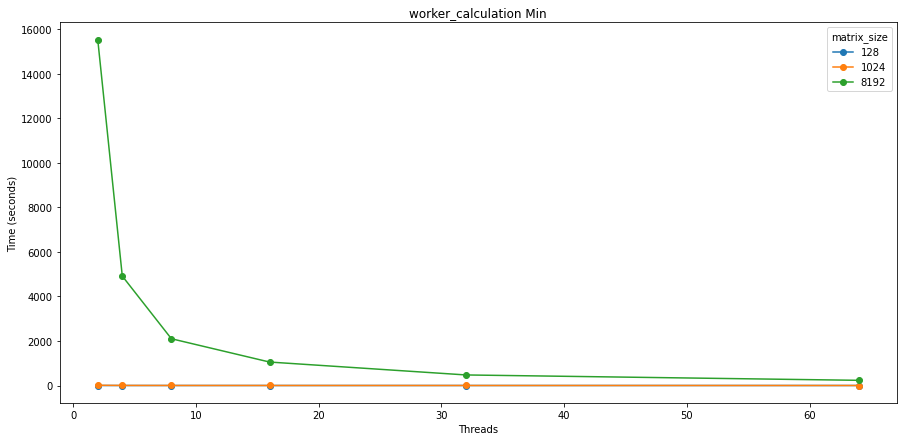

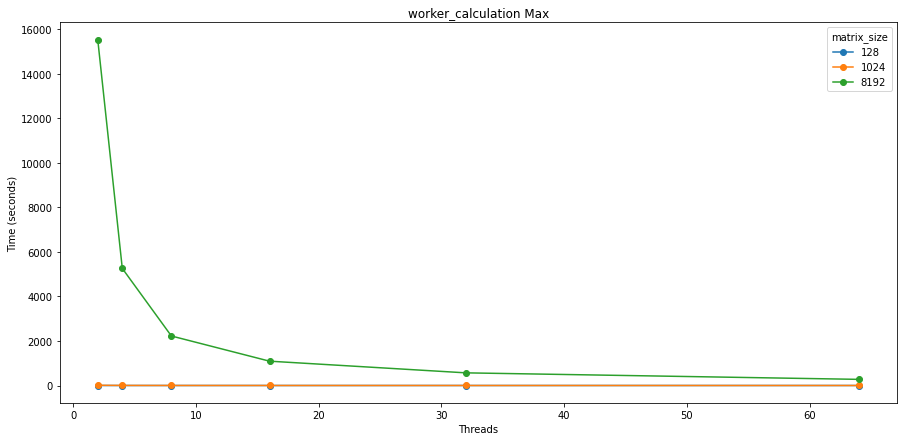

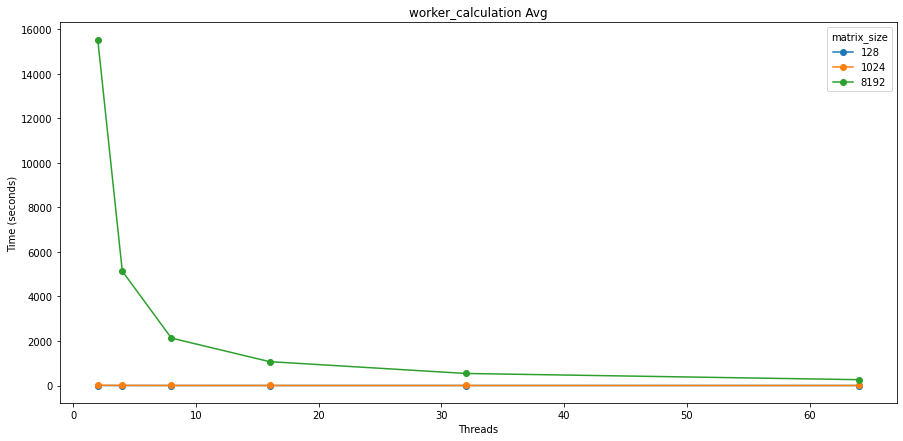

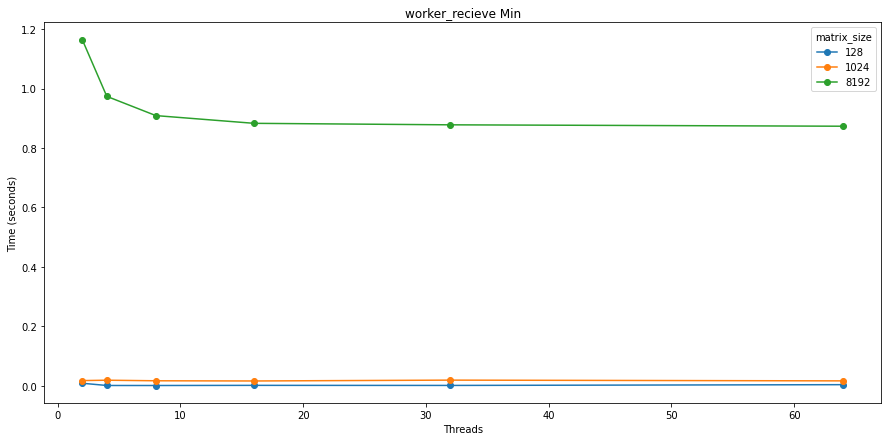

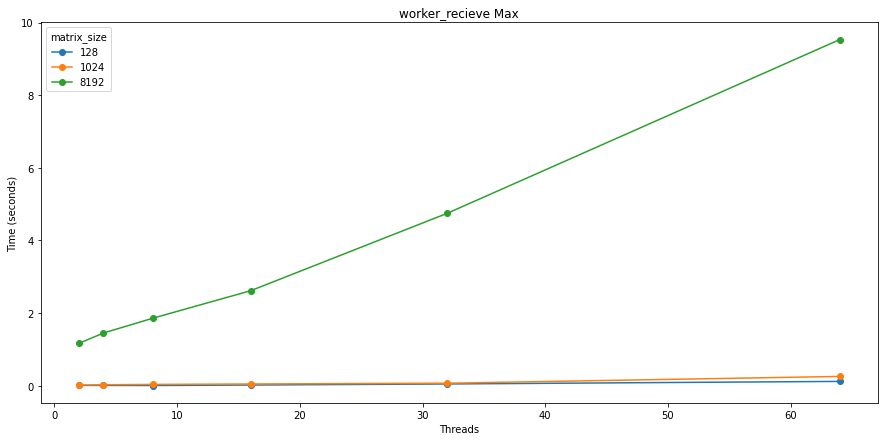

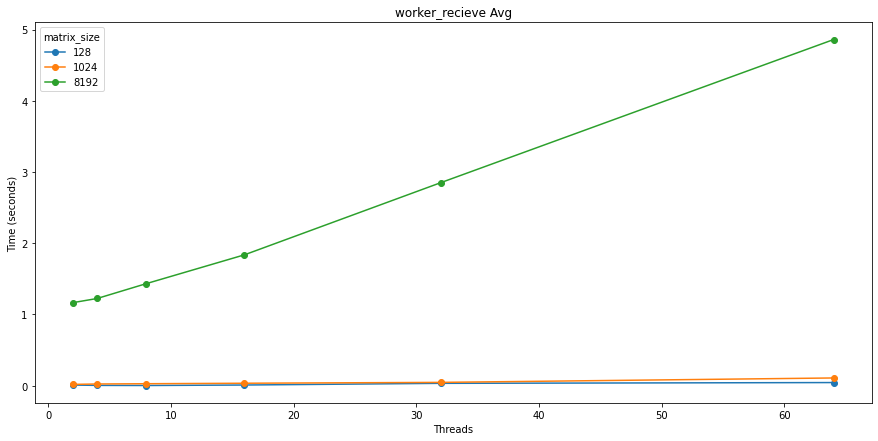

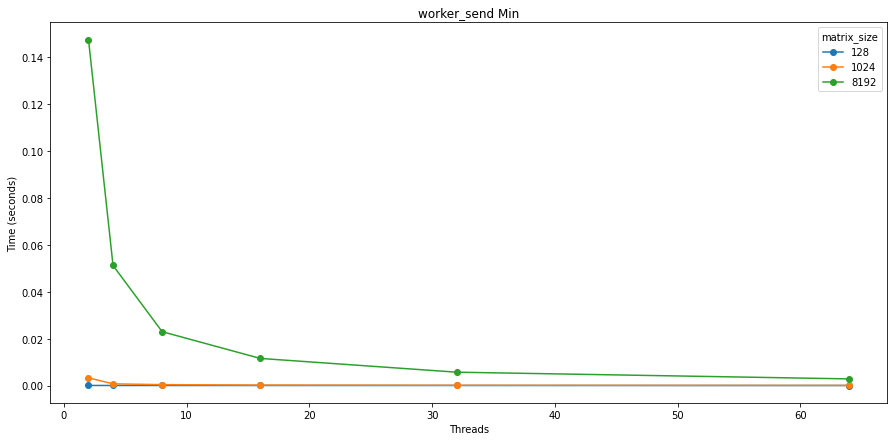

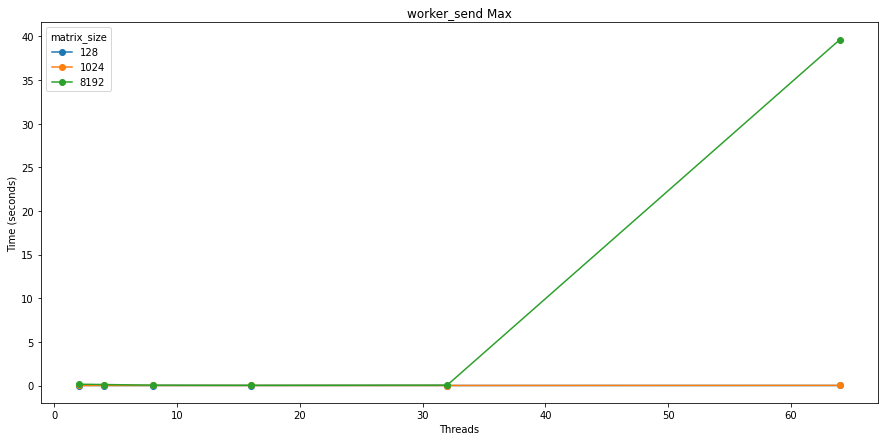

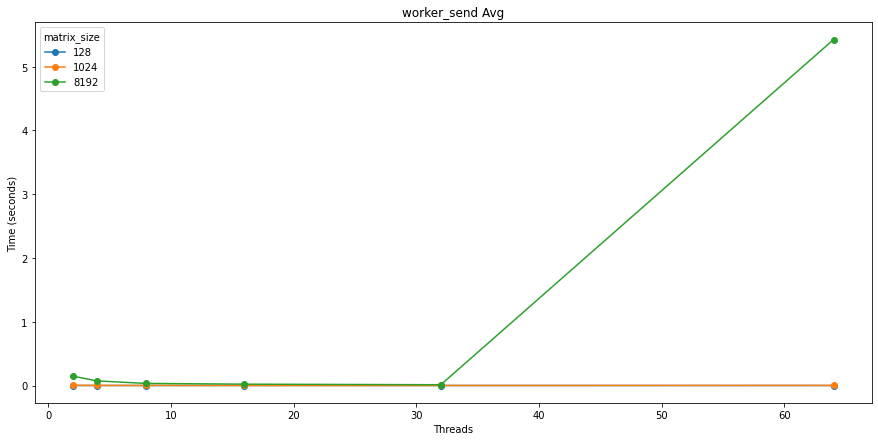

In [24]:
# plot min, max, avg
for node in tk.graph.traverse():
    if node.frame["name"] == 'worker_recieve' or node.frame["name"] == 'worker_calculation' or node.frame["name"] == 'worker_send':
        plot_pandas(
            df=tk.dataframe.loc[node, "Min time/rank"].unstack(level="array_size"),
            title=node.frame["name"] + " Min",
            xlabel="Number of Processes",
            ylabel="Time (seconds)",
        )
        plot_pandas(
            df=tk.dataframe.loc[node, "Max time/rank"].unstack(level="array_size"),
            title=node.frame["name"] + " Max",
            xlabel="Number of Processes",
            ylabel="Time (seconds)",
        )
        plot_pandas(
            df=tk.dataframe.loc[node, "Avg time/rank"].unstack(level="array_size"),
            title=node.frame["name"] + " Avg",
            xlabel="Number of Processes",
            ylabel="Time (seconds)",
        )

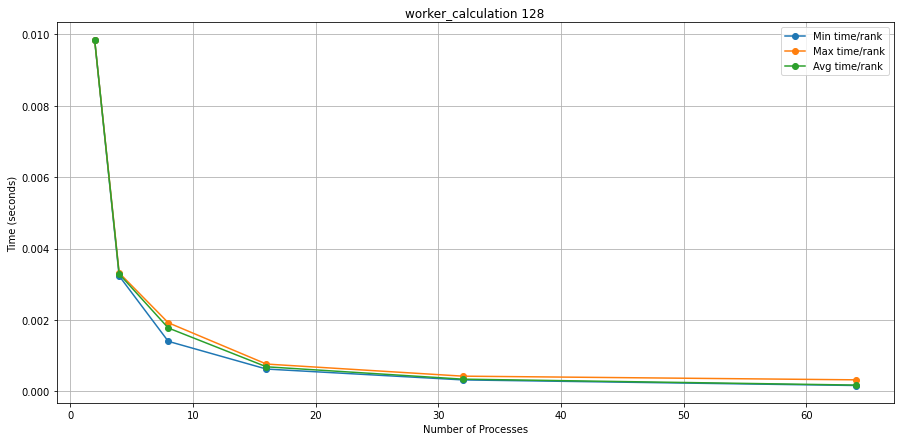

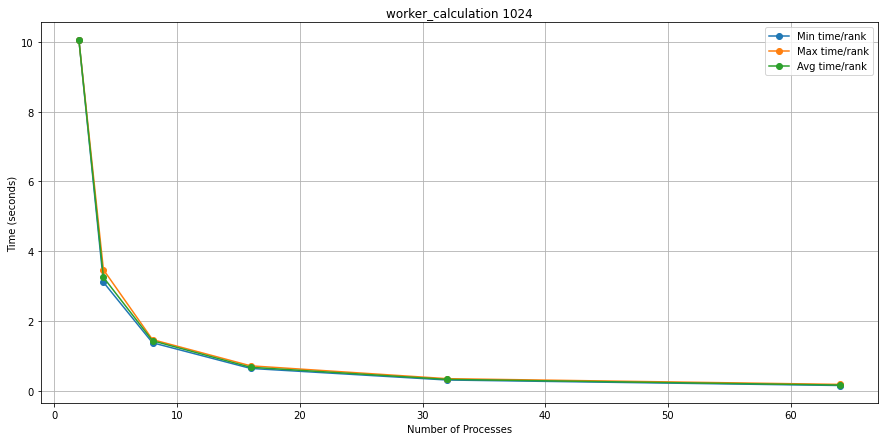

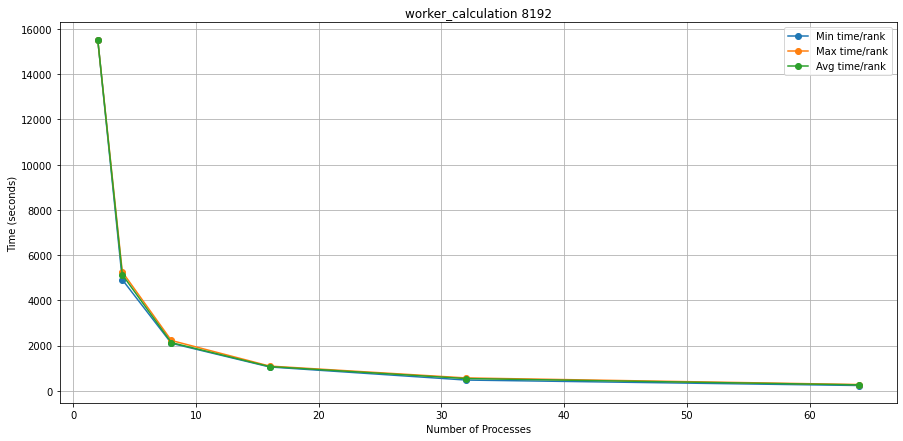

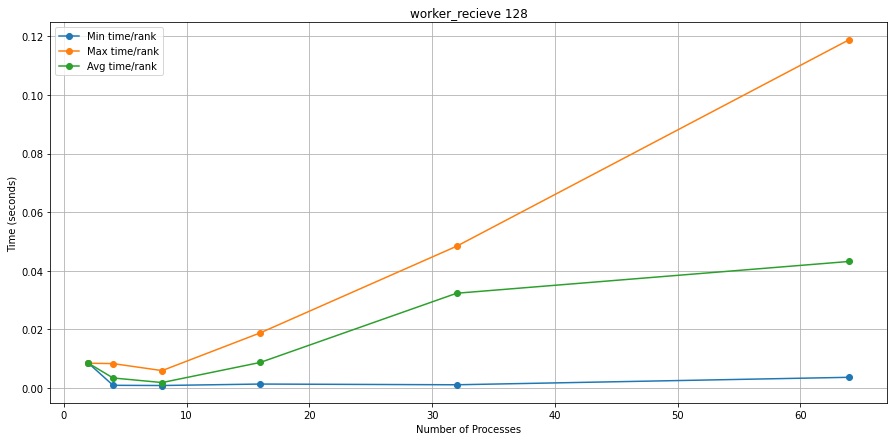

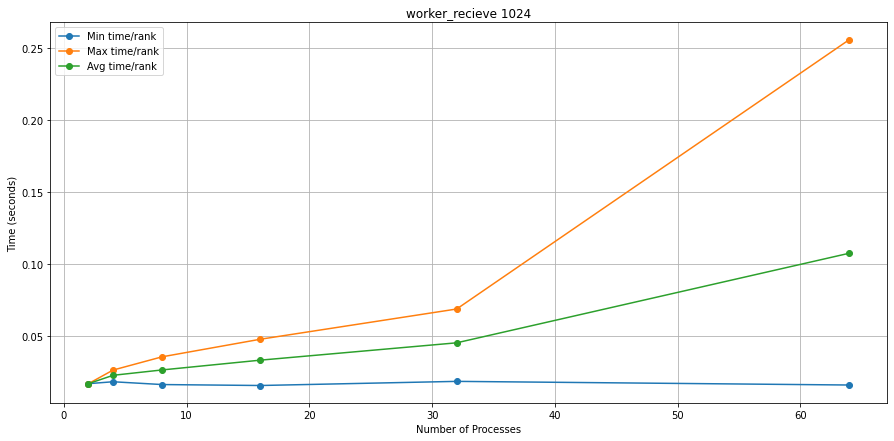

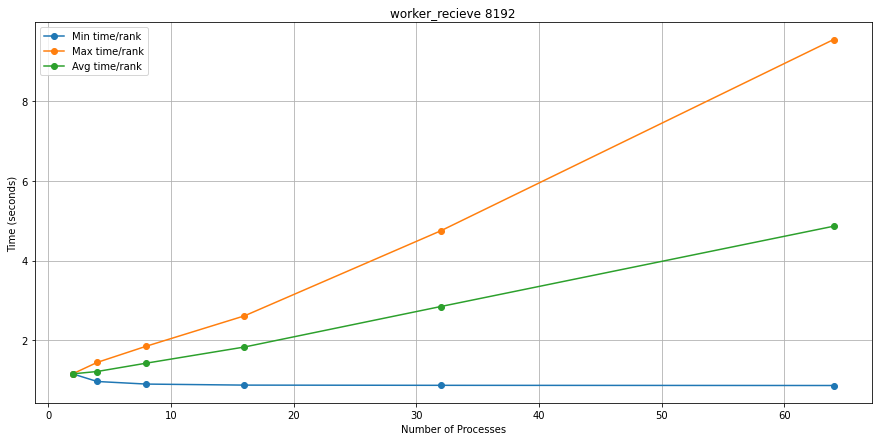

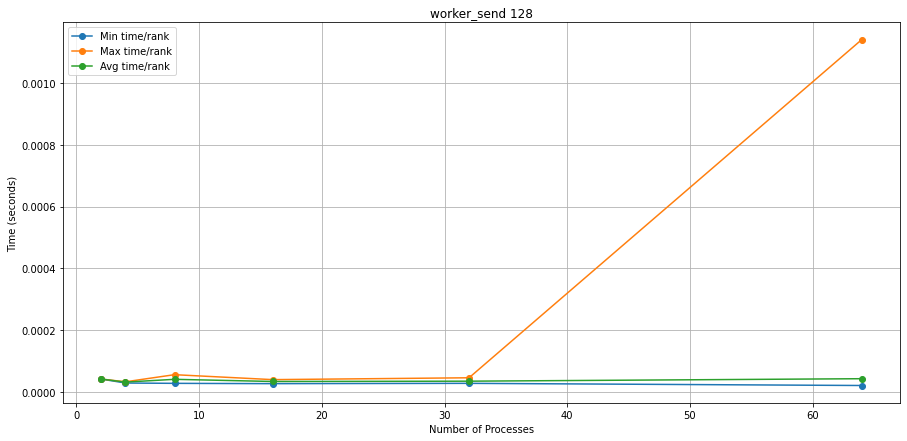

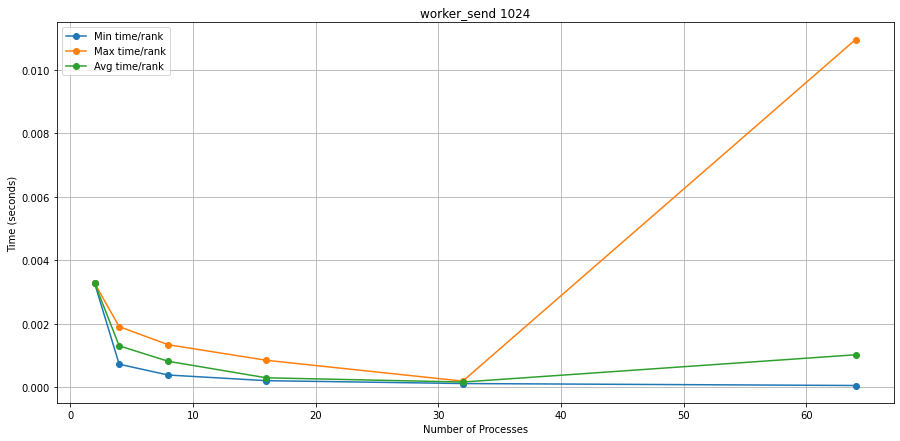

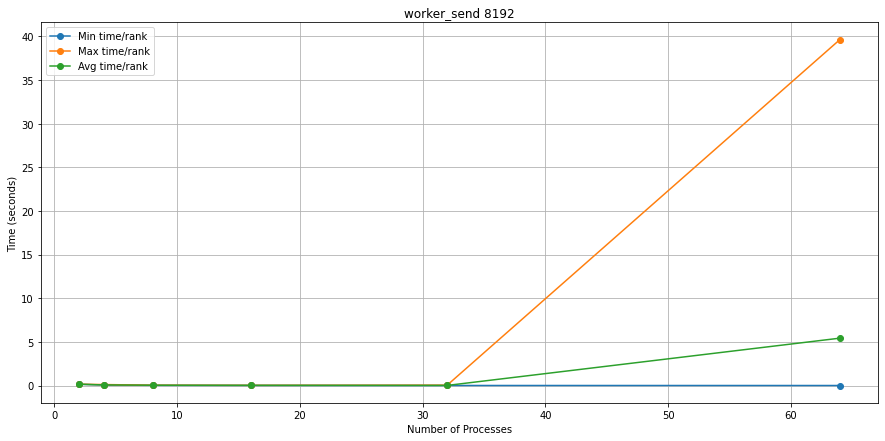

In [36]:
# MAIN GRAPHS FOR WORKERS
# separate graphs by matrix sizes and plot max, min, avg
grouped = tk.dataframe.groupby(['node', 'array_size'])
# print(grouped)

for (node, array_size), group in grouped:
    if node.frame["name"] != 'worker_recieve' and node.frame["name"] != 'worker_calculation' and node.frame["name"] != 'worker_send':
        continue

    # Sort the groups by number of processes to match x axis values
    group_sorted = group.sort_values(by='num_procs')
    plt.figure(figsize=(15, 7))

    # Plot times
    plt.plot(processes, group_sorted['Min time/rank'], label='Min time/rank', marker='o')
    plt.plot(processes, group_sorted['Max time/rank'], label='Max time/rank', marker='o')
    plt.plot(processes, group_sorted['Avg time/rank'], label='Avg time/rank', marker='o')
    
    plt.title(node.frame["name"] + " " + str(array_size))
    plt.xlabel('Number of Processes')
    plt.ylabel('Time (seconds)')
    plt.legend()

    # Add grid for better readability
    plt.grid(True)
    plt.show()


In [14]:
def plot_mpl(df, title, xlabel, ylabel):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(
        df,
        marker='o',
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(array_size)
    plt.xscale("log", base=2)
    plt.xticks(threads)
    ax.set_xticklabels(threads)
    plt.show()
    return fig, ax

NameError: name 'matrix_sizes' is not defined

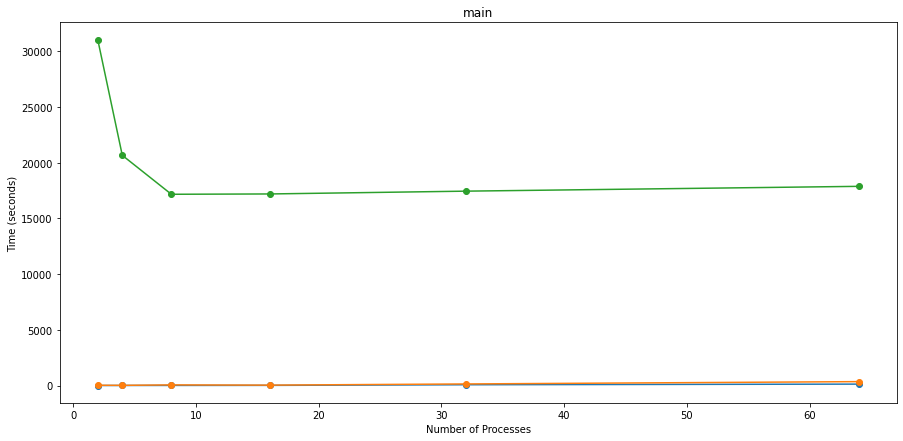

In [16]:
for node in tk.graph.traverse():
    plot_mpl(
        df=tk.dataframe.loc[node, "Total time"].unstack(level="array_size"),
        title=node.frame["name"],
        xlabel="Number of Processes",
        ylabel="Time (seconds)",
    )